In [1]:
import io
from copy import copy
from collections import OrderedDict
#from hamcrest import none
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.signal import hilbert
import h5py
import mne
import hypyp
import requests
import os
import PyQt5
import sys
import pickle
#print(sys.path)
sys.path.append('C:/Users/Administrateur/MilitaryCoordination/')

from hypyp import (
    prep,)  # need pip install https://api.github.com/repos/autoreject/autoreject/zipball/master
from hypyp import analyses
from hypyp import prep
from hypyp import stats
from hypyp import viz
import autoreject

import copy
import my_utils
from my_utils import extract_trials, create_sub_epochs, AR_local_custom, ICA_autocorrect, define_event_dictionary, create_erp_epochs


path = r"F:/hyperscanning_mne"
raw_path = r"F:/Hyperscanning_eeg_data"
prep_path = os.path.join(path, "preprocessed data")
log_path = os.path.join(path, "logs")



In [90]:
name = 'P1P2_15_02.bdf'
file_path = os.path.join(raw_path, name)
log_folder_path = os.path.join(log_path, name)
if not os.path.isdir(log_folder_path):
    os.makedirs(log_folder_path)

split_name = name.split("P")
pair = int ((int(split_name[1]) + 1) / 2)


#if (pair == 33) or (pair == 28) or (pair == 15) or (pair == 12):
#   continue

print('beyond')
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_1 = raw.info.ch_names[:64]
raw_1 = raw.pick_channels(channels_1)
del raw
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_2 = raw.info.ch_names[76:140]
raw_2 = raw.pick_channels(channels_2)
del raw

            # get the montage that we will use
biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
#biosemi64_montage.plot()  # 2D

# change the channel names in our epochs so that they are the same as the montage
channels = biosemi64_montage.ch_names
mapping_1 = {}
mapping_2 = {}
for i in range(len(channels)):
    mapping_1[raw_1.info['chs'][i]['ch_name']] = str(channels[i])
    mapping_2[raw_2.info['chs'][i]['ch_name']] = str(channels[i])
mne.rename_channels(raw_1.info, mapping_1)
mne.rename_channels(raw_2.info, mapping_2)

raw_1.pick_channels(channels)
raw_2.pick_channels(channels)


# set the montage to the epochs
raw_1.set_montage(biosemi64_montage)
raw_2.set_montage(biosemi64_montage)

raw = mne.io.read_raw_bdf(file_path)
raw_events = mne.find_events(raw, shortest_event = 0)


beyond
Extracting EDF parameters from F:\Hyperscanning_eeg_data\P1P2_15_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8728575  =      0.000 ...  4262.000 secs...
Extracting EDF parameters from F:\Hyperscanning_eeg_data\P1P2_15_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8728575  =      0.000 ...  4262.000 secs...
Extracting EDF parameters from F:\Hyperscanning_eeg_data\P1P2_15_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2780 events found
Event IDs: [    1     2     3     4     5     6     7     8   100   101   110   111
   112   113   114   115   141   142   143   144   146   147   148   150
   200   201   210   211   212   213   214   215   241   242  

In [33]:
def define_event_dictionary():
    # Define the possible values for each variable
    one_values = ['Synchronous', 'Complementary', 'Individual']
    two_values = ['Egalitarian', 'LeaderFollower', 'FollowerLeader']
    three_values = ['Success', 'Failure']
    four_values = ['Start', 'Checkpoint', 'Desyncpoint', 'Error']
    five_values = ['1', '2']

    # Create an empty dictionary to store the event IDs
    event_id = {}

    # Loop over all possible combinations of values for the five variables
    for one in one_values:
        for two in two_values:
            for three in three_values:
                for four in four_values:
                    for five in five_values:
                        # Create a key string using the values of the five variables
                        key = f"{one}/{two}/{three}/{four}/{five}"
                        
                        # Create an event ID using a unique integer value
                        event_id[key] = len(event_id) + 1

    return event_id


def create_erp_epochs(trials, sfreq, old_events, old_event_id, event_id):
    event_values = old_events[:, 2]
    event_samples = old_events[:,0]
    events = np.empty(3,)
    event_info = np.empty(3,) # (trial number, successful, baseline)
    # go through all the trials we found
    for trial_index in range(1, np.size(trials,0)):
        trial_start = trials[trial_index, 0]
        trial_end = trials[trial_index, 1]
        condition = trials[trial_index, 3]
        success = trials[trial_index, 4]
        condition_string = [k for k, v in old_event_id.items() if v == condition][0]
        if success == 1:
            success_string = 'Success'
        else:
            success_string = 'Failure'

        # now get the event at the start of the trial
        kind = 'Start'

        key = f"{condition_string}/{success_string}/{kind}/{'1'}"
        id = event_id[key]
        event = [trial_start, 0, id]
        events = np.vstack((events, np.array(event)))


        # find the events happening within this trial
        trial_events = np.where((trial_start < event_samples) & (trial_end > event_samples))[0]

        
        # conditions from which we want to have checkpoints
        if condition != 1:
            # find the first cross of the checkpoint
            crossed_points = []
            for trial_event in trial_events:
                event_value = str(event_values[trial_event])
                    
                if len(event_value) < 3:
                    continue
                event_sample = event_samples[trial_event]    
                player_crossed = int(event_value[0:2])
                checkpoint = int(event_value[2])
                event_sample = event_samples[trial_event]
                
                if ((player_crossed == 21) or (player_crossed == 11)) and (checkpoint not in crossed_points):
                    # add checkpoint to list
                    crossed_points.append(checkpoint)
                    
                    # only add the event when the last one was not less than 500ms before so as to not mix them too much
                    if (event_sample - events[-1, 0]) > sfreq:

                        first_crosser = event_value[0]
                        kind = 'Checkpoint'
                        key = f"{condition_string}/{success_string}/{kind}/{first_crosser}"
                        id = event_id[key]
                        event = [event_sample, 0, id]
                        events = np.vstack((events, np.array(event)))
                # or if they are game over
                elif ((player_crossed == 24) or (player_crossed == 14)):

                    first_crosser = event_value[0]
                    kind = 'Error'
                    key = f"{condition_string}/{success_string}/{kind}/{first_crosser}"
                    id = event_id[key]
                    event = [event_sample, 0, id]
                    events = np.vstack((events, np.array(event)))
                    break

            # find the first cross of the desync points
            crossed_points = []
            for trial_event in trial_events:
                event_value = str(event_values[trial_event])
                
                if len(event_value) < 3:
                    continue
                    
                player_crossed = int(event_value[0:2])
                checkpoint = int(event_value[2])

                # only for desync points
                if ((player_crossed == 20) or (player_crossed == 10)) and (checkpoint not in crossed_points):
                    # add desync point to list 
                    first_crosser = event_value[0]
                    kind = 'Desyncpoint'
                    key = f"{condition_string}/{success_string}/{kind}/{first_crosser}"
                    id = event_id[key]
                    event = [event_sample, 0, id]
                    events = np.vstack((events, np.array(event)))

                    crossed_points.append(checkpoint)
                          
    events = (np.rint(events)).astype(int)

    return events

[65536   114   214 ...   215   250   150]
8617915
89
Complementary/FollowerLeader/Failure/Start/1
741595
97
Individual/Egalitarian/Success/Start/1
743848
99
Individual/Egalitarian/Success/Checkpoint/1
747567
99
Individual/Egalitarian/Success/Checkpoint/1
755862
99
Individual/Egalitarian/Success/Checkpoint/1
775524
97
Individual/Egalitarian/Success/Start/1
778533
99
Individual/Egalitarian/Success/Checkpoint/1
783303
99
Individual/Egalitarian/Success/Checkpoint/1
786585
99
Individual/Egalitarian/Success/Checkpoint/1
805114
97
Individual/Egalitarian/Success/Start/1
808019
99
Individual/Egalitarian/Success/Checkpoint/1
812115
99
Individual/Egalitarian/Success/Checkpoint/1
814883
99
Individual/Egalitarian/Success/Checkpoint/1
833653
97
Individual/Egalitarian/Success/Start/1
836152
99
Individual/Egalitarian/Success/Checkpoint/1
839361
99
Individual/Egalitarian/Success/Checkpoint/1
844441
99
Individual/Egalitarian/Success/Checkpoint/1
862871
97
Individual/Egalitarian/Success/Start/1
865335
99

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_19660\3678463067.py:30: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, event_id=event_id, sfreq=sfreq)


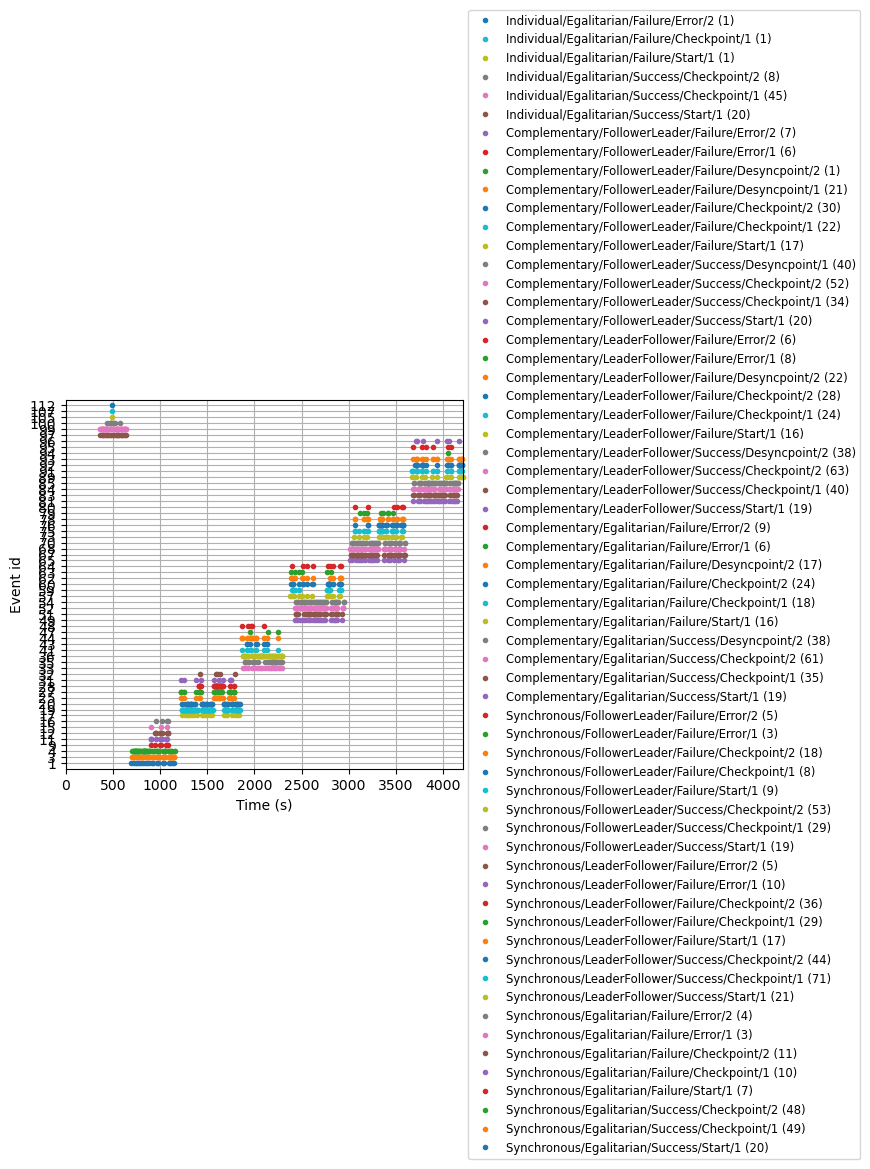

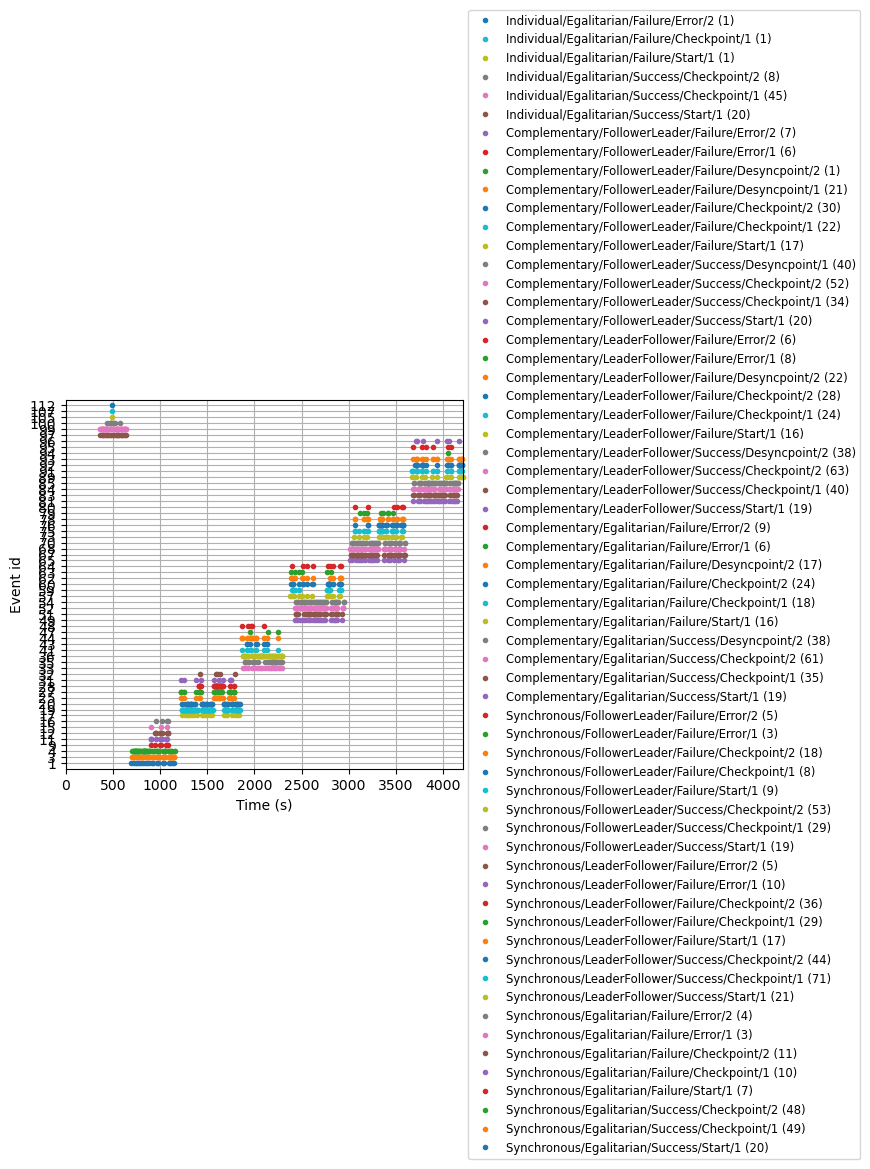

In [35]:
trials = extract_trials(raw_events)
#print(trials)
sfreq = raw.info['sfreq']
#mne.viz.plot_events(events, sfreq=raw.info['sfreq']);
#print("fs" + str(raw.info['sfreq']))
old_event_id = {'Synchronous/Egalitarian': 2, 'Synchronous/LeaderFollower': 3, 'Synchronous/FollowerLeader': 4, 'Individual/Egalitarian': 5, 'Complementary/Egalitarian': 6, 'Complementary/LeaderFollower': 7, 'Complementary/FollowerLeader': 8}
event_id = define_event_dictionary()
events = create_erp_epochs(trials, sfreq, raw_events, old_event_id, event_id)

path = r"F:/hyperscanning_mne"
raw_path = r"F:/Hyperscanning_eeg_data"
prep_path = os.path.join(path, "preprocessed data")
log_path = os.path.join(path, "logs")

for i, ev in zip(events[:,0], events[:,2]):
    print(i)
    print(ev)
    print([k for k, v in event_id.items() if v == ev][0])

# delete entries from event ids that are not present in the events
keys_to_delete = []
for  key, value in event_id.items():
    if not (value in events[:,2]):
        keys_to_delete.append(key)
for key in keys_to_delete:
    del event_id[key]



mne.viz.plot_events(events, event_id=event_id, sfreq=sfreq)


In [67]:
pre_stim = 2
post_stim = 2

epochs_1 = mne.Epochs(raw_1, events, event_id, event_repeated = 'drop', on_missing = 'ignore', tmin=-pre_stim, tmax=post_stim, preload=True)
epochs_2 = mne.Epochs(raw_2, events, event_id, event_repeated = 'drop', on_missing = 'ignore', tmin=-pre_stim, tmax=post_stim, preload=True)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1237 matching events found
Setting baseline interval to [-2.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1237 events and 8193 original time points ...
0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1237 matching events found
Setting baseline interval to [-2.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1237 events and 8193 original time points ...
0 bad epochs dropped


In [76]:
# here we will load in the preprocessed data to try to get out the erp that we want
pair = 6
file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "pair_" + str(pair))     
with open(file_path , "rb") as input_file:
    cleaned_epochs_AR, dic_AR = pickle.load(input_file)


In [71]:
# remove the extra rejected channels from the individual trials
file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "bad_labels_pair_" + str(pair))
with open(file_path , "rb") as input_file:
    bad_labels = pickle.load(input_file)
# merge labels
bad_labels = np.clip(bad_labels[0] + bad_labels[1], 0, 1)
for cleaned_epochs in cleaned_epochs_AR:
    for epoch in range(np.size(bad_labels, 0)):
        for channel in range(np.size(bad_labels, 1)):
            if bad_labels[epoch, channel] == 0:
                cleaned_epochs._data[epoch, channel, :] = np.nan

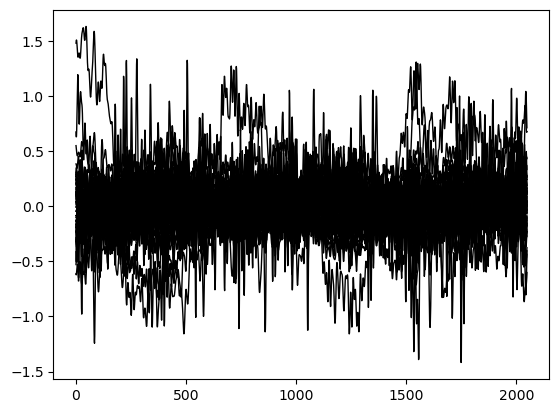

In [74]:
data = cleaned_epochs_AR[0].get_data()
for channel in range(64):
    averaged_channel = np.nanmean(data[:,channel,:], axis = 0) # of not nanmean then it will ignore every channel with one removed epoch
    #if np.sum(averaged_channel) != np.nan:
    plt.plot(averaged_channel*10**6, color = 'black', linewidth = 1)
        #plt.savefig(os.path.join(log_folder_path, 'post_custom_reject_epochs_'+ str(part)))
plt.show()

In [55]:

epochs_1 = cleaned_epochs_AR[0]
epochs_2 = cleaned_epochs_AR[1]
desync_epochs = epochs_1['Error']
sync_epochs = epochs_1['Checkpoint']

#sub_epochs = epochs_2['Desyncpoint']

In [81]:
print(sub_epochs.ch_names[47])

Cz


In [56]:

# Filter the data in the beta band (13-30 Hz)
desync_epochs_beta = desync_epochs.copy().filter(l_freq=13, h_freq=30)
sync_epochs_beta = sync_epochs.copy().filter(l_freq=13, h_freq=30)
# Compute the amplitude envelope
desync_epochs_beta.apply_hilbert(envelope=True)
sync_epochs_beta.apply_hilbert(envelope=True)

# Filter the envelope in the delta band (1-4 Hz)
desync_epochs_delta = desync_epochs_beta.copy().filter(l_freq=1, h_freq=5)
sync_epochs_delta = sync_epochs_beta.apply_hilbert(envelope=True)


Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 521 samples (1.018 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 13 - 30 Hz


[Parallel(n_jobs=1)]: Done 4096 out of 4096 | elapsed:    0.7s finished



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 521 samples (1.018 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 56960 out of 56960 | elapsed:   10.7s finished


Setting up band-pass filter from 1 - 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4096 out of 4096 | elapsed:    3.7s finished


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


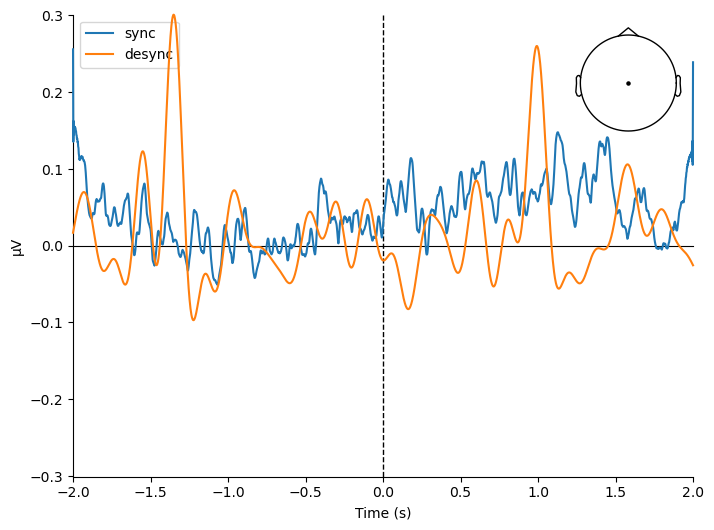

[<Figure size 800x600 with 2 Axes>]

In [82]:
# Extract the ERP for the Cz channel
desync_epochs_delta.apply_baseline((-1, -0.5))
erp_desync = desync_epochs_delta.average(picks = [47])
sync_epochs_delta.apply_baseline((-1, -0.5))
erp_sync = sync_epochs_delta.average(picks = [47])

#erp_desync._data = erp_desync._data[:, 500:1500]
#erp_sync._data = erp_desync._data[:, 500:1500]
# Plot the ERP
evokeds = dict(sync = erp_sync, desync = erp_desync)
mne.viz.plot_compare_evokeds(evokeds)



In [ ]:

evoked_desync = []
evoked_sync = []

for pair in range(1,44):

    if (pair) > 20:
        group = 'civilian'
    else:
        group = 'military'

    # here we will load in the preprocessed data to try to get out the erp that we want
    try:
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "pair_" + str(pair))     
        with open(file_path , "rb") as input_file:
            cleaned_epochs_AR, dic_AR = pickle.load(input_file)



        # remove the extra rejected channels from the individual trials
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "bad_labels_pair_" + str(pair))
        with open(file_path , "rb") as input_file:
            bad_labels = pickle.load(input_file)
    except:
        print('trial not available')
        continue
    # merge labels
    bad_labels = np.clip(bad_labels[0] + bad_labels[1], 0, 1)
    for cleaned_epochs in cleaned_epochs_AR:
        for epoch in range(np.size(bad_labels, 0)):
            for channel in range(np.size(bad_labels, 1)):
                if bad_labels[epoch, channel] == 0:
                    cleaned_epochs._data[epoch, channel, :] = 0

    epochs_1 = cleaned_epochs_AR[0]
    epochs_2 = cleaned_epochs_AR[1]

    for epochs in [epochs_1, epochs_2]:
        desync_epochs = epochs['Desyncpoint']
        sync_epochs = epochs['Checkpoint']

        
        # Filter the data in the beta band (13-30 Hz)
        desync_epochs_beta = desync_epochs.copy().filter(l_freq=13, h_freq=30)
        sync_epochs_beta = sync_epochs.copy().filter(l_freq=13, h_freq=30)
        # Compute the amplitude envelope
        desync_epochs_beta.apply_hilbert(envelope=True)
        sync_epochs_beta.apply_hilbert(envelope=True)

        # Filter the envelope in the delta band (1-4 Hz)
        desync_epochs_delta = desync_epochs_beta.copy().filter(l_freq=1, h_freq=5)
        sync_epochs_delta = sync_epochs_beta.apply_hilbert(envelope=True)

        desync_epochs_delta.apply_baseline((-1, -0.5))
        erp_desync = desync_epochs_delta.average()

        sync_epochs_delta.apply_baseline((-1, -0.5))
        erp_sync = sync_epochs_delta.average()

        evoked_desync.append(erp_desync)
        evoked_sync.append(erp_sync)


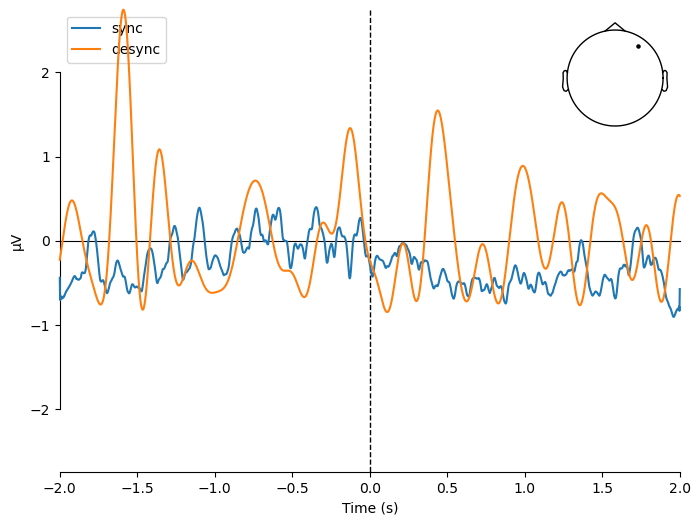

[<Figure size 800x600 with 2 Axes>]

In [77]:
grand_average_desync = mne.combine_evoked(evoked_desync, weights = 'equal')
grand_average_sync = mne.combine_evoked(evoked_sync, weights = 'equal')


evokeds = dict(sync = grand_average_sync, desync = grand_average_desync)
mne.viz.plot_compare_evokeds(evokeds)


In [ ]:
%%capture
evoked_desync_leader = []
evoked_sync_leader = []
evoked_desync_follower = []
evoked_sync_follower = []

for pair in range(1,44):

    if (pair) > 20:
        group = 'civilian'
    else:
        group = 'military'

    # here we will load in the preprocessed data to try to get out the erp that we want
    try:
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "pair_" + str(pair))     
        with open(file_path , "rb") as input_file:
            cleaned_epochs_AR, dic_AR = pickle.load(input_file)



        # remove the extra rejected channels from the individual trials
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "bad_labels_pair_" + str(pair))
        with open(file_path , "rb") as input_file:
            bad_labels = pickle.load(input_file)


        # merge labels
        bad_labels = np.clip(bad_labels[0] + bad_labels[1], 0, 1)
        for cleaned_epochs in cleaned_epochs_AR:
            for epoch in range(np.size(bad_labels, 0)):
                for channel in range(np.size(bad_labels, 1)):
                    if bad_labels[epoch, channel] == 0:
                        cleaned_epochs._data[epoch, channel, :] = 0

        epochs_1 = cleaned_epochs_AR[0]
        epochs_2 = cleaned_epochs_AR[1]
    except:
        print('pair not available')
   

    for leader_condition in ['LeaderFollower', 'FollowerLeader']:
        try: 
            i = 1
            for epochs in [epochs_1, epochs_2]:
                desync_epochs = epochs[leader_condition + '/' + 'Desyncpoint']
                sync_epochs = epochs[leader_condition + '/' + 'Checkpoint']
                print(desync_epochs)

                
                # Filter the data in the beta band (13-30 Hz)
                desync_epochs_beta = desync_epochs.copy().filter(l_freq=13, h_freq=30, verbose = False)
                sync_epochs_beta = sync_epochs.copy().filter(l_freq=13, h_freq=30, verbose = False)
                # Compute the amplitude envelope
                desync_epochs_beta.apply_hilbert(envelope=True, verbose = False)
                sync_epochs_beta.apply_hilbert(envelope=True, verbose = False)

                # Filter the envelope in the delta band (1-4 Hz)
                desync_epochs_delta = desync_epochs_beta.copy().filter(l_freq=0.2, h_freq=5, verbose = False)
                sync_epochs_delta = sync_epochs_beta.copy().filter(l_freq=0.2, h_freq=5, verbose = False)

                desync_epochs_delta.apply_baseline((-1, -0.5))
                erp_desync = desync_epochs_delta.average(picks = [47], verbose = False)

                sync_epochs_delta.apply_baseline((-1, -0.5))
                erp_sync = sync_epochs_delta.average(picks = [47], verbose = False)
                
                # add the correct players to the correct list
                if leader_condition == 'LeaderFollower':
                    if i == 2:
                        evoked_desync_leader.append(erp_desync)
                        evoked_sync_leader.append(erp_sync)
                    else:
                        evoked_desync_follower.append(erp_desync)
                        evoked_sync_follower.append(erp_sync)
                else:
                    if i == 1:
                        evoked_desync_leader.append(erp_desync)
                        evoked_sync_leader.append(erp_sync)
                    else:
                        evoked_desync_follower.append(erp_desync)
                        evoked_sync_follower.append(erp_sync)
                print('saved')
                i+=1
        except:
            print('condition not present')
       

# make an average of all the players
grand_average_desync_leader = mne.combine_evoked(evoked_desync_leader, weights = 'equal')
grand_average_desync_follower = mne.combine_evoked(evoked_desync_follower, weights = 'equal')
grand_average_sync_leader = mne.combine_evoked(evoked_sync_leader, weights = 'equal')
grand_average_sync_follower = mne.combine_evoked(evoked_sync_follower, weights = 'equal')

evokeds_desync = dict(leader = grand_average_desync_leader, follower = grand_average_desync_follower)
evokeds_sync = dict(leader = grand_average_sync_leader, follower = grand_average_sync_follower)
mne.viz.plot_compare_evokeds(evokeds_desync)
mne.viz.plot_compare_evokeds(evokeds_sync)   




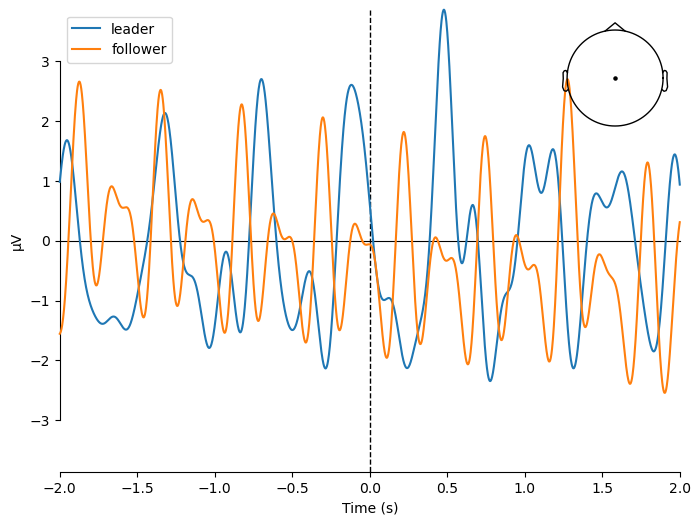

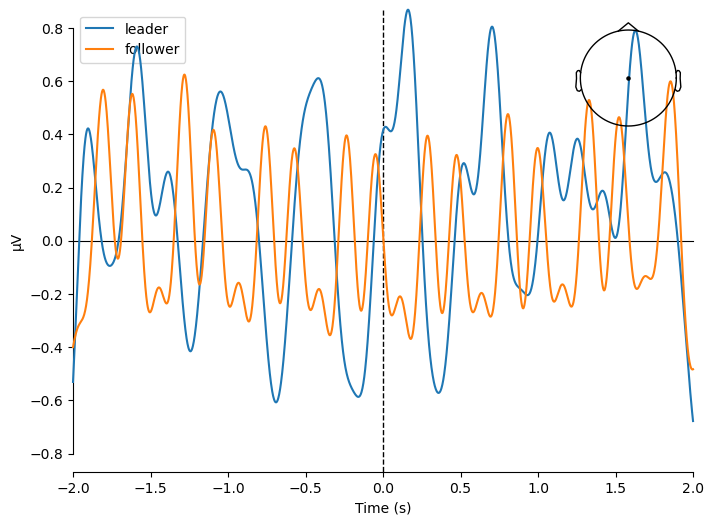

[<Figure size 800x600 with 2 Axes>]

In [24]:
mne.viz.plot_compare_evokeds(evokeds_desync)
mne.viz.plot_compare_evokeds(evokeds_sync)



In [ ]:
desync_stack = np.zeros((2049,))
sync_stack = np.zeros((2049,))

for pair in range(1,44):

    if (pair) > 20:
        group = 'civilian'
    else:
        group = 'military'

    # here we will load in the preprocessed data to try to get out the erp that we want
    try:
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "pair_" + str(pair))     
        with open(file_path , "rb") as input_file:
            cleaned_epochs_AR, dic_AR = pickle.load(input_file)



        # remove the extra rejected channels from the individual trials
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "bad_labels_pair_" + str(pair))
        with open(file_path , "rb") as input_file:
            bad_labels = pickle.load(input_file)

        """
        # merge labels
        bad_labels = np.clip(bad_labels[0] + bad_labels[1], 0, 1)
        for cleaned_epochs in cleaned_epochs_AR:
            for epoch in range(np.size(bad_labels, 0)):
                for channel in range(np.size(bad_labels, 1)):
                    if bad_labels[epoch, channel] == 0:
                        cleaned_epochs._data[epoch, channel, :] = 0
        """
        epochs_1 = cleaned_epochs_AR[0]
        epochs_2 = cleaned_epochs_AR[1]

    except:
        print('pair not available')
        continue
    
    try:
        desync_pair_epochs = [epochs_1['Desyncpoint'], epochs_2['Desyncpoint']]
        sync_pair_epochs = [epochs_1['Checkpoint'], epochs_2['Checkpoint']]
    except:
        continue
    
    condition = 1
    for pair_epochs in [desync_pair_epochs, sync_pair_epochs]:
        condition_epochs_1 = pair_epochs[0]
        condition_epochs_2 = pair_epochs[1]
        # Filter the data in the beta band (13-30 Hz)
        epochs_1_beta = condition_epochs_1.copy().filter(l_freq=13, h_freq=30, verbose = False)
        epochs_2_beta = condition_epochs_2.copy().filter(l_freq=13, h_freq=30, verbose = False)
        # Compute the amplitude envelope
        epochs_1_beta.apply_hilbert(envelope=True)
        epochs_2_beta.apply_hilbert(envelope=True)

        # Filter the envelope in the delta band (1-4 Hz)
        #epochs_1_delta = epochs_1_beta.copy().filter(l_freq=0.1, h_freq=5, verbose = False)
        #epochs_2_delta = epochs_2_beta.copy().filter(l_freq=0.1, h_freq=5, verbose = False)

        epochs_1_delta = epochs_1_beta.get_data()
        epochs_2_delta = epochs_2_beta.get_data()

        

        # get the angles of the signal
        # (trial, channel, time)
        epochs_1_angles = np.angle(hilbert(epochs_1_delta, axis = 2))
        epochs_2_angles = np.angle(hilbert(epochs_2_delta, axis = 2))

        # now we put them together so that we can calculate the KOP between them
        combined_epoch_angles = np.stack((epochs_1_angles, epochs_2_angles), axis = 3)

        # calculate the KOP
        epochs_KOP_in_time = np.abs(np.mean(np.exp(1j*combined_epoch_angles), axis = 3))

        # select channel and average over trials
        KOP_average_in_time = np.mean(epochs_KOP_in_time[:,47,:], axis = 0) 
        if condition == 1:
            desync_stack = np.vstack(((desync_stack, KOP_average_in_time )))
        else:
            sync_stack = np.vstack(((sync_stack, KOP_average_in_time )))  
        condition +=1

average_desync = np.mean(desync_stack, axis = 0)
average_sync = np.mean(sync_stack, axis = 0)

plt.plot(average_desync)
plt.plot(average_sync)
plt.show()

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]



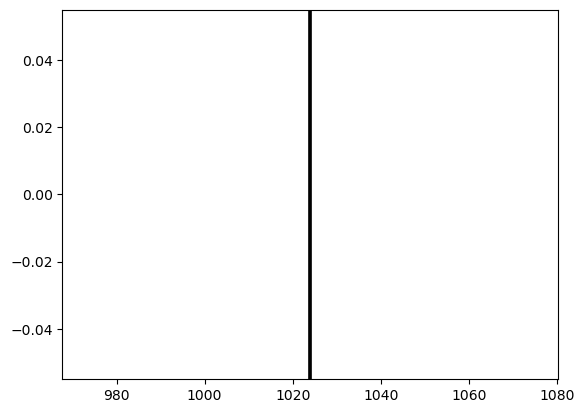

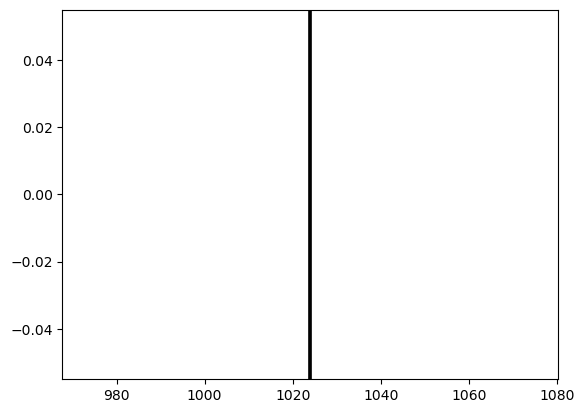

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3344\2652516325.py:29: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(desync_stack, axis = 0), alpha = 0.5)


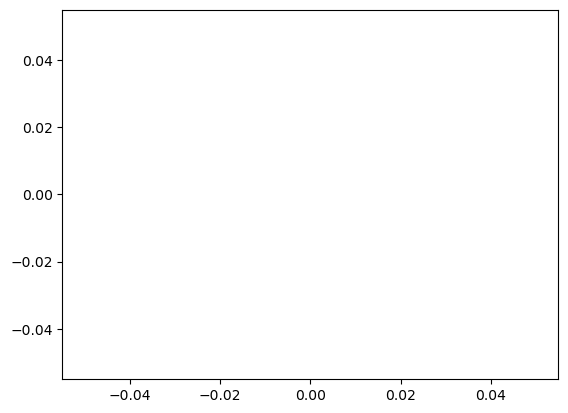

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3344\2652516325.py:36: RuntimeWarning: Mean of empty slice
  desync_stack[i, :] = (desync_stack[i, :] - np.nanmean(desync_stack[i, :])) / np.nanstd(desync_stack[i, :])
c:\Users\Administrateur\AppData\Local\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


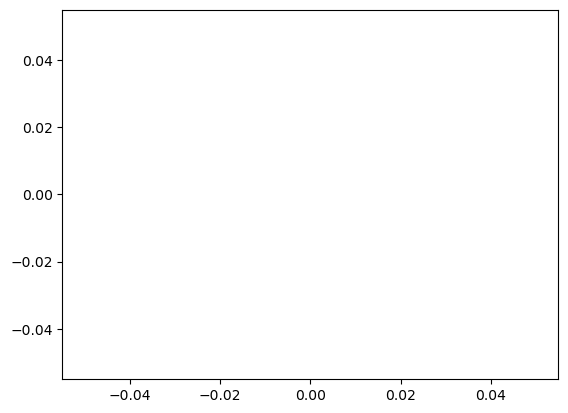

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3344\2652516325.py:39: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(desync_stack, axis = 0), alpha = 0.5)


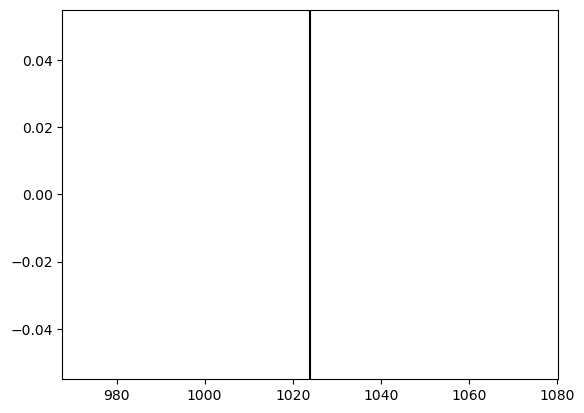

In [63]:
%matplotlib inline


print()
for i in range(np.size(sync_stack,0)):
    #if np.mean(sync_stack[i,:]) < 0.9:
    #    continue
    plt.plot(sync_stack[i,:], alpha = 0.5)
    plt.axvline(x = 1024, color = 'black')
plt.show()




print()
for i in range(np.size(desync_stack,0)):
    if np.mean(desync_stack[i,:]) < 0.9:
        continue
    plt.plot(desync_stack[i,:], alpha = 0.5)
    plt.axvline(x = 1024, color = 'black')
plt.show()



for i in range(np.size(desync_stack,0)):
    if np.mean(desync_stack[i,:]) < 0.9:
        desync_stack[i,:] = np.nan
plt.plot(np.nanmean(desync_stack, axis = 0), alpha = 0.5)


plt.show()
for i in range(np.size(sync_stack,0)):
    if np.mean(desync_stack[i,:]) < 0.9:
        desync_stack[i,:] = np.nan
    else:
        desync_stack[i, :] = (desync_stack[i, :] - np.nanmean(desync_stack[i, :])) / np.nanstd(desync_stack[i, :])
        plt.plot(desync_stack[i, :])
plt.show()
plt.plot(np.nanmean(desync_stack, axis = 0), alpha = 0.5)
plt.axvline(x = 1024, color = 'black')

    
plt.show()
    




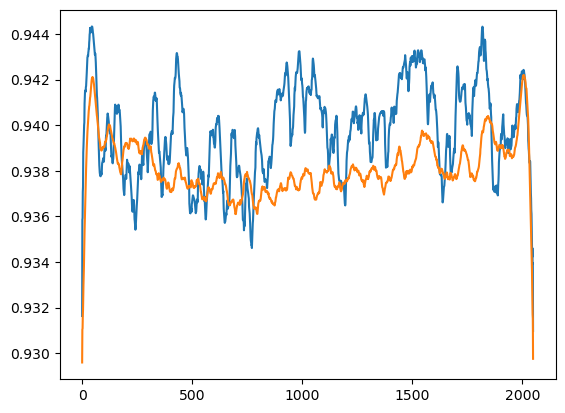

In [43]:
plt.plot(average_desync)
plt.plot(average_sync)
plt.show()

print(np.size(data))

[0.95305266 0.95575    0.95526578 ... 0.95737716 0.95648591 0.95322932]


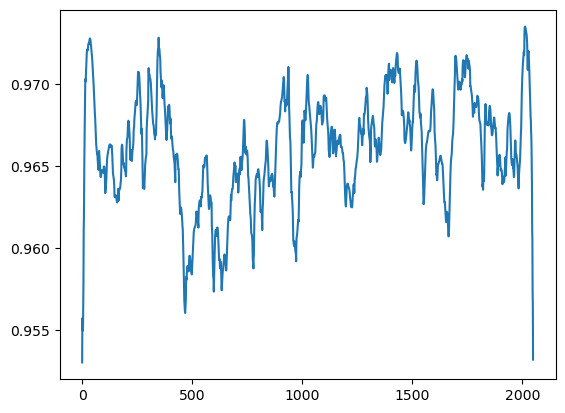

In [19]:
epochs_1_angles = np.angle(hilbert(epochs_1_delta, axis = 2))
epochs_2_angles = np.angle(hilbert(epochs_2_delta, axis = 2))

# now we put them together so that we can calculate the KOP between them
combined_epoch_angles = np.stack((epochs_1_angles, epochs_2_angles), axis = 3)

# calculate the KOP
epochs_KOP_in_time = np.abs(np.mean(np.exp(1j*combined_epoch_angles), axis = 3))

# select channel and average over trials
KOP_average_in_time = np.mean(epochs_KOP_in_time[:,47,:], axis = 0) 
print(KOP_average_in_time)
plt.plot(KOP_average_in_time)
plt.show()

In [70]:
# in this plot we check always which player is first and then we group the ERP's so that we can see if it is reflected in the brain signatures

evoked_desync_leader = []
evoked_sync_leader = []
evoked_desync_follower = []
evoked_sync_follower = []

for pair in range(1,44):

    if (pair) > 20:
        group = 'civilian'
    else:
        group = 'military'

    # here we will load in the preprocessed data to try to get out the erp that we want
    try:
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "pair_" + str(pair))     
        with open(file_path , "rb") as input_file:
            cleaned_epochs_AR, dic_AR = pickle.load(input_file)



        # remove the extra rejected channels from the individual trials
        file_path = os.path.join("F:/hyperscanning_mne/time_locked/", "bad_labels_pair_" + str(pair))
        with open(file_path , "rb") as input_file:
            bad_labels = pickle.load(input_file)

        """
        # merge labels
        bad_labels = np.clip(bad_labels[0] + bad_labels[1], 0, 1)
        for cleaned_epochs in cleaned_epochs_AR:
            for epoch in range(np.size(bad_labels, 0)):
                for channel in range(np.size(bad_labels, 1)):
                    if bad_labels[epoch, channel] == 0:
                        cleaned_epochs._data[epoch, channel, :] = 0

        epochs_1 = cleaned_epochs_AR[0]
        epochs_2 = cleaned_epochs_AR[1]
        """
    except:
        print('pair not available')
   

    for first_crosser in ['1', '2']:
        try: 
            i = 1
            for epochs in [epochs_1, epochs_2]:
                # pick only certain channels
                epochs.pick([47])    

                # and now we reject channels with a too high ptp for that channel
                print(np.shape(epochs.get_data())) 
                epochs.reject(dict(eeg = 40e-6))  
                print(np.shape(epochs.get_data())) 

                # select the epochs that we want
                desync_epochs = epochs['Desyncpoint' + '/' + first_crosser]
                sync_epochs = epochs['Checkpoint' + '/' + first_crosser]

                
                # Filter the data in the beta band (13-30 Hz)
                desync_epochs_beta = desync_epochs.copy().filter(l_freq=13, h_freq=30, verbose = False)
                sync_epochs_beta = sync_epochs.copy().filter(l_freq=13, h_freq=30, verbose = False)
                # Compute the amplitude envelope
                desync_epochs_beta.apply_hilbert(envelope=True)
                sync_epochs_beta.apply_hilbert(envelope=True)

                # Filter the envelope in the delta band (1-4 Hz)
                desync_epochs_delta = desync_epochs_beta.copy().filter(l_freq=0.1, h_freq=5, verbose = False)
                sync_epochs_delta = sync_epochs_beta.copy().filter(l_freq=0.1, h_freq=5, verbose = False)

                desync_epochs_delta.apply_baseline((-1, -0.5))
                erp_desync = desync_epochs_delta.average(picks = [47])

                sync_epochs_delta.apply_baseline((-1, -0.5))
                erp_sync = sync_epochs_delta.average(picks = [47])
                
                # add the correct players to the correct list
                if first_crosser == '1':
                    if i == 2:
                        evoked_desync_leader.append(erp_desync)
                        evoked_sync_leader.append(erp_sync)
                    else:
                        evoked_desync_follower.append(erp_desync)
                        evoked_sync_follower.append(erp_sync)
                else:
                    if i == 1:
                        evoked_desync_leader.append(erp_desync)
                        evoked_sync_leader.append(erp_sync)
                    else:
                        evoked_desync_follower.append(erp_desync)
                        evoked_sync_follower.append(erp_sync)
            i+=1
        except:
            print('condition not present')
        

# make an average of all the players
grand_average_desync_leader = mne.combine_evoked(evoked_desync_leader, weights = 'equal')
grand_average_desync_follower = mne.combine_evoked(evoked_desync_follower, weights = 'equal')
grand_average_sync_leader = mne.combine_evoked(evoked_sync_leader, weights = 'equal')
grand_average_sync_follower = mne.combine_evoked(evoked_sync_follower, weights = 'equal')

evokeds_desync = dict(sync = grand_average_desync_leader, follower = grand_average_desync_follower)
evokeds_sync = dict(sync = grand_average_sync_leader, follower = grand_average_sync_follower)
mne.viz.plot_compare_evokeds(evokeds_desync)
mne.viz.plot_compare_evokeds(evokeds_sync)   


condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition not present
condition 

c:\Users\Administrateur\AppData\Local\Anaconda3\lib\site-packages\mne\evoked.py:1087: RuntimeWarning: divide by zero encountered in double_scalars
  new_nave = 1. / np.sum(weights ** 2 / naves)


IndexError: list index out of range

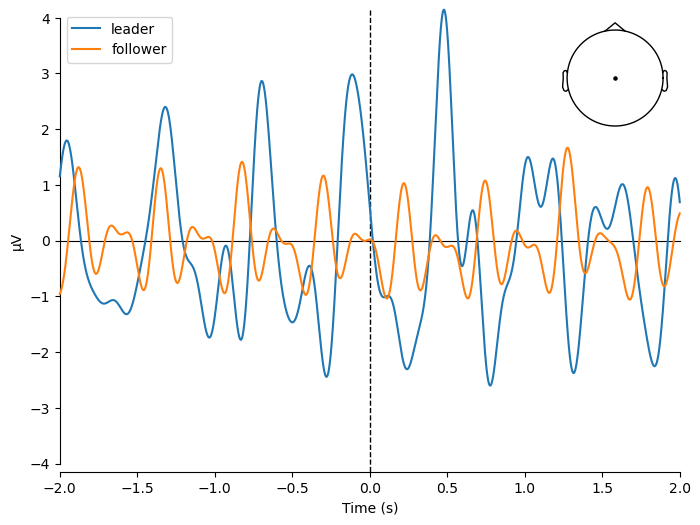

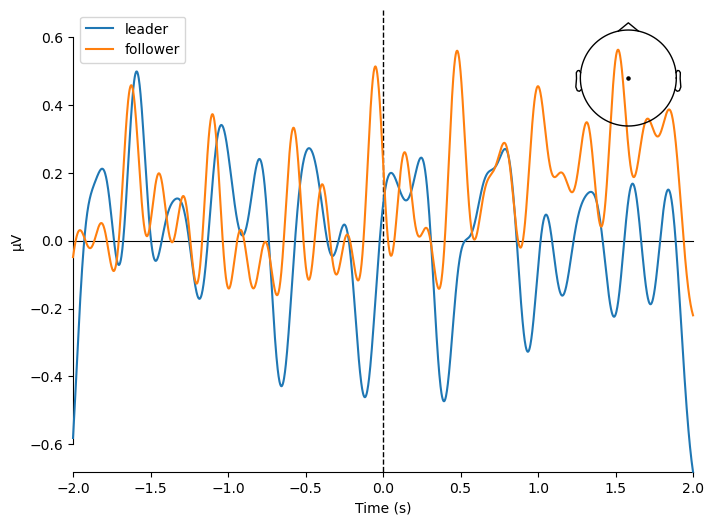

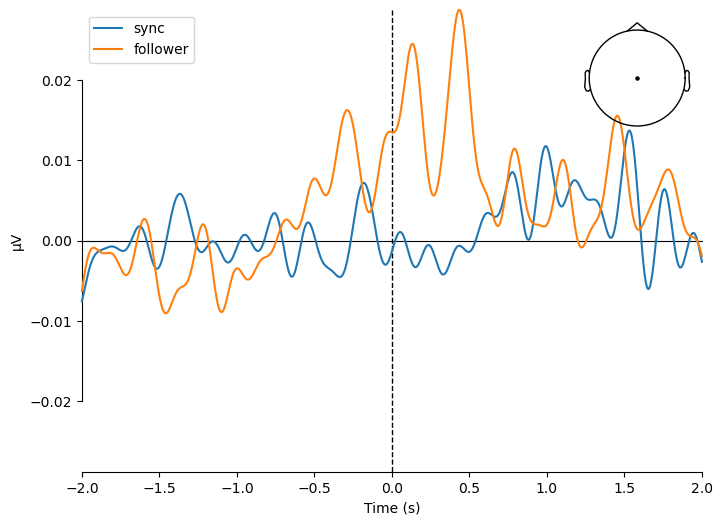

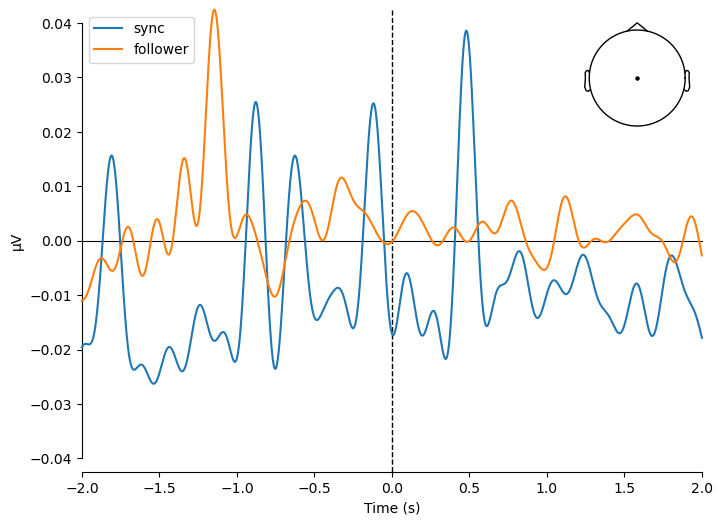

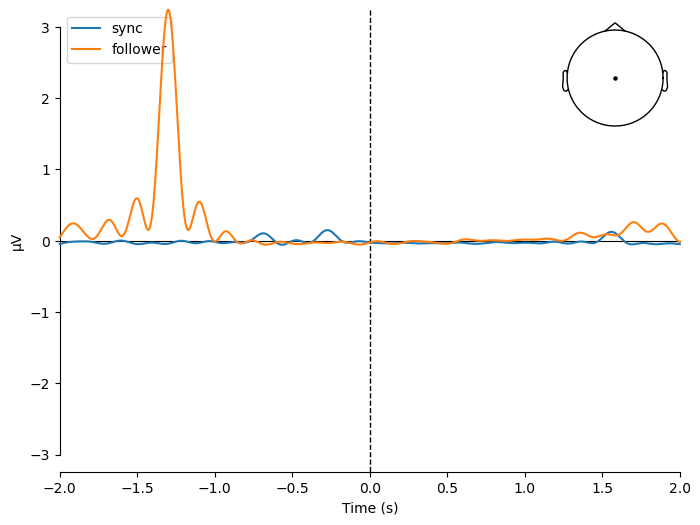

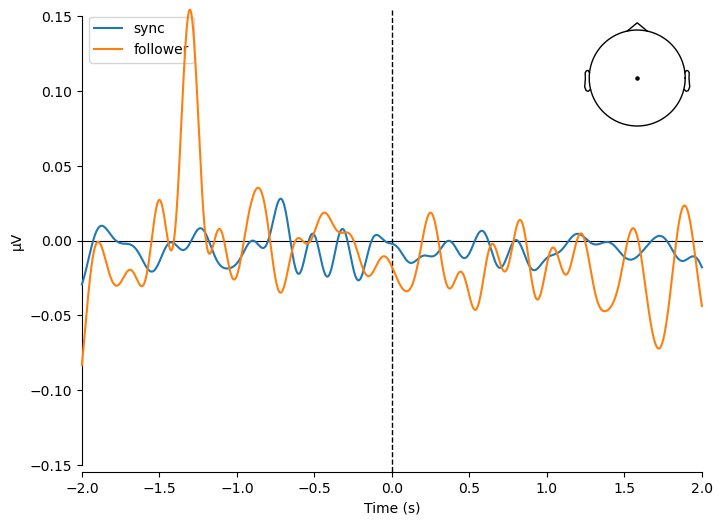

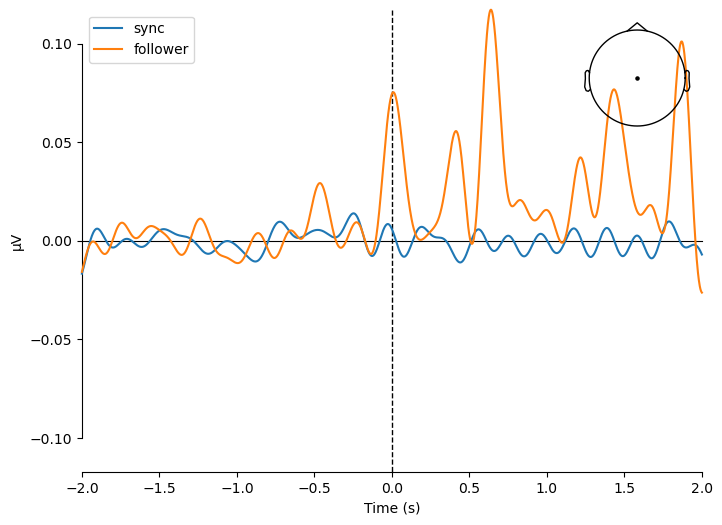

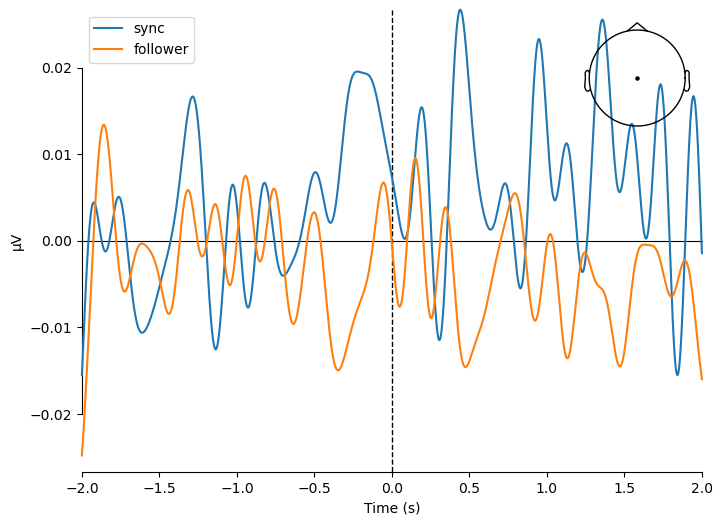

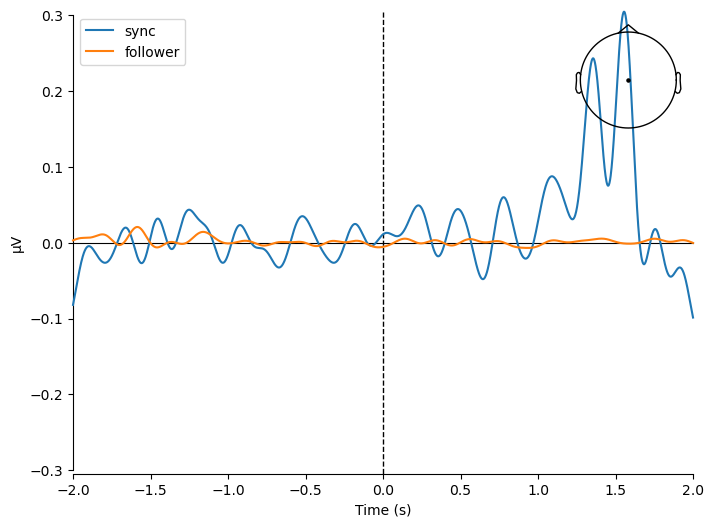

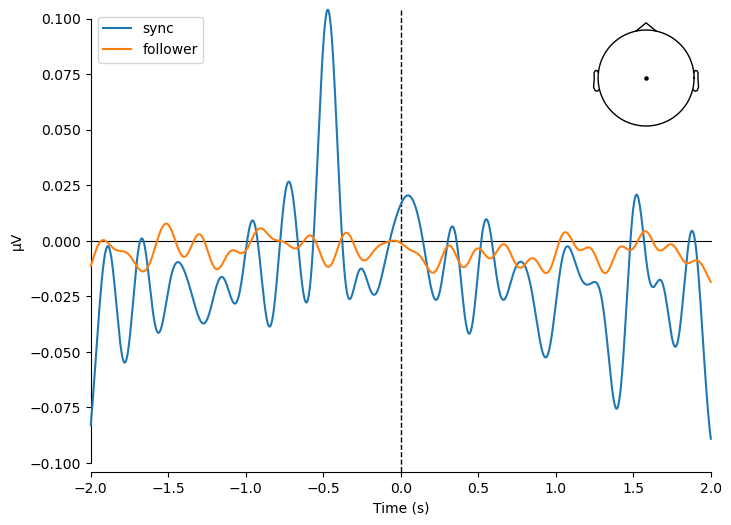

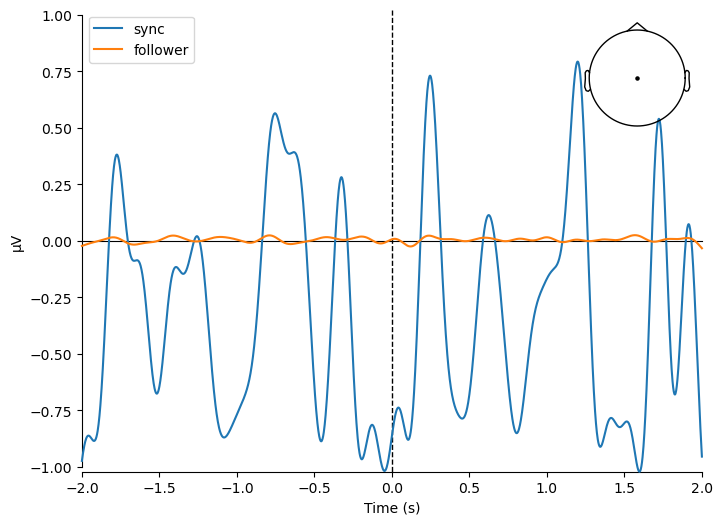

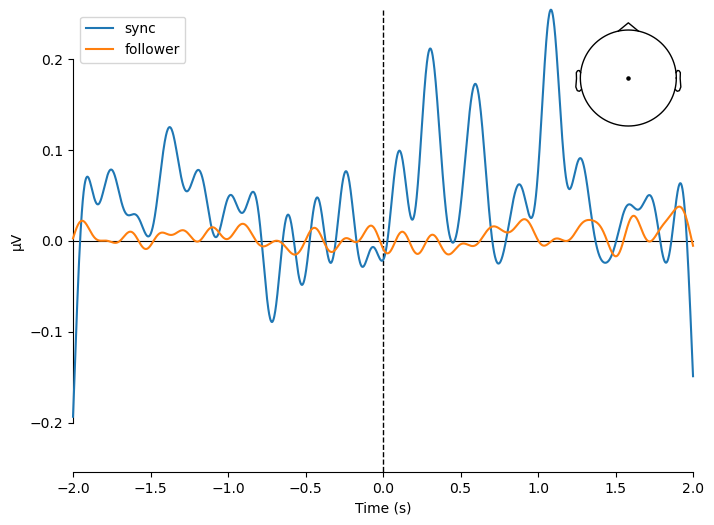

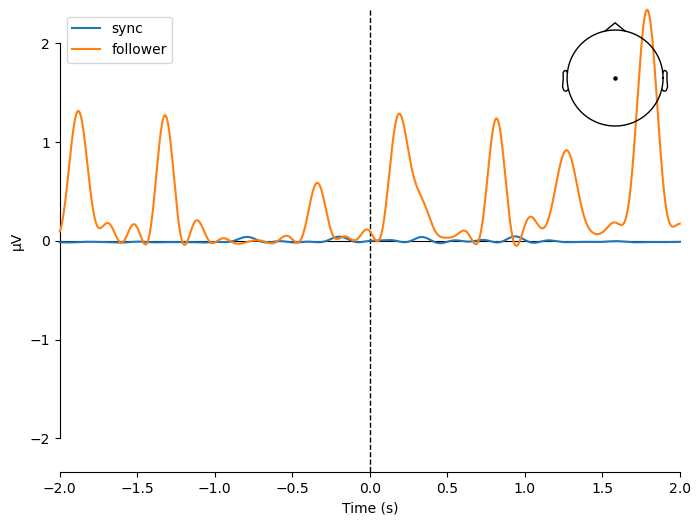

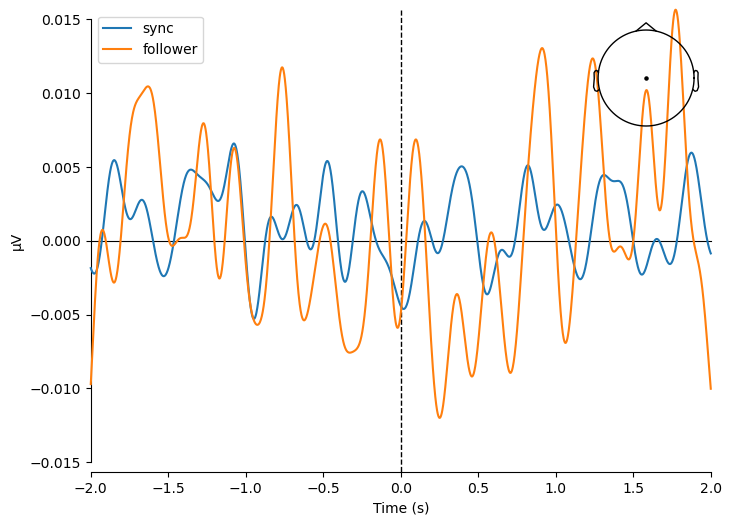

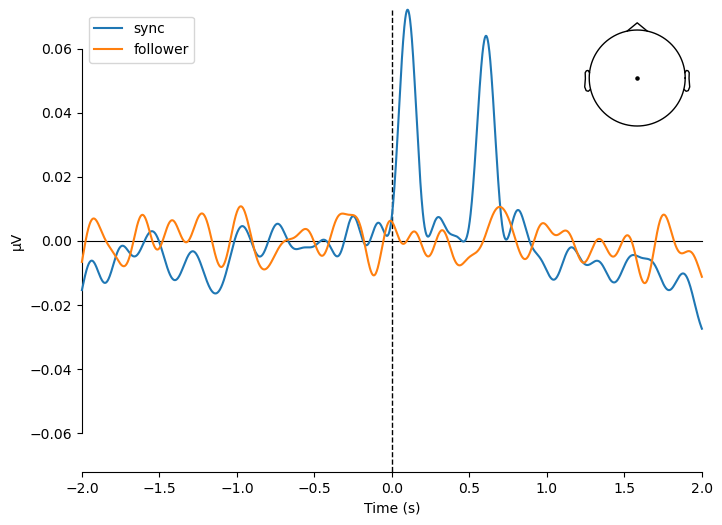

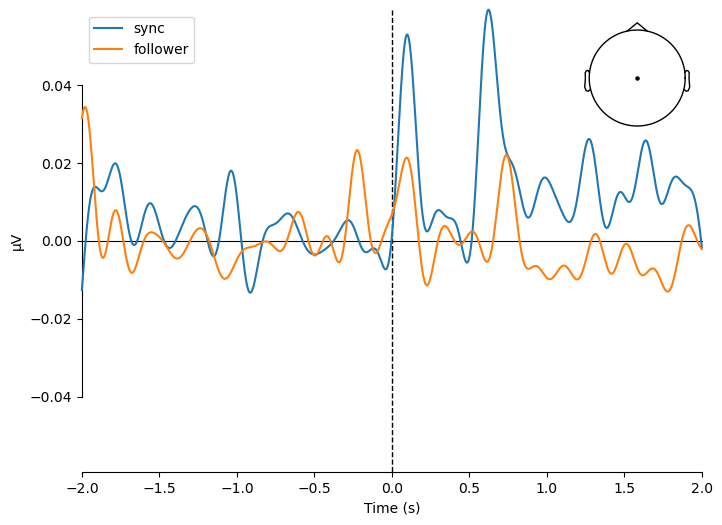

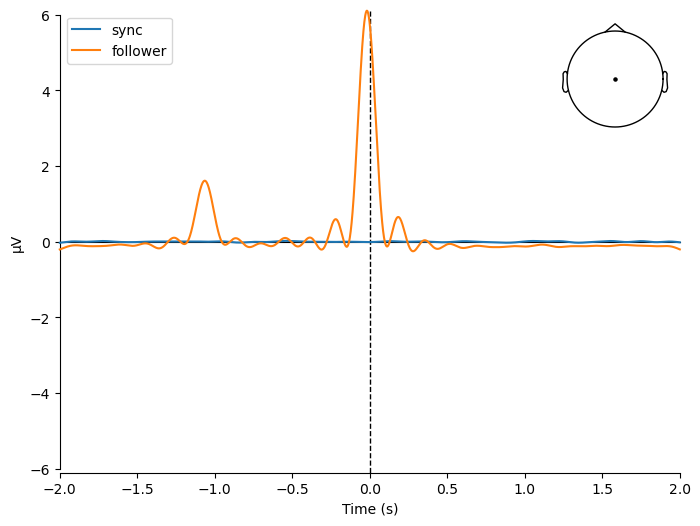

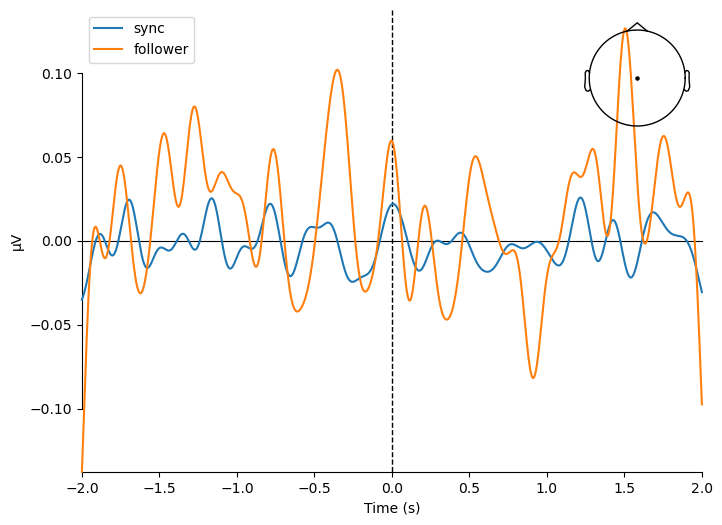

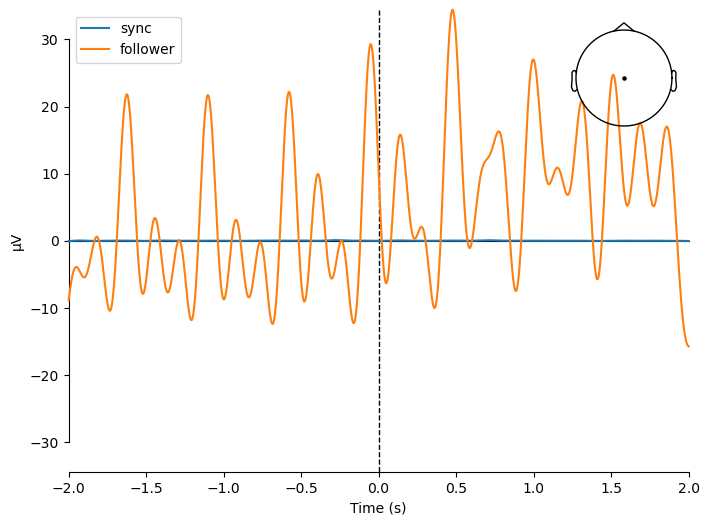

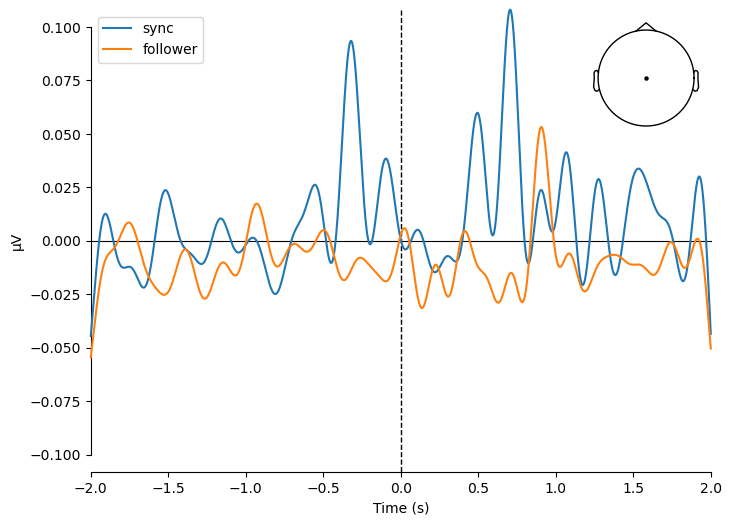

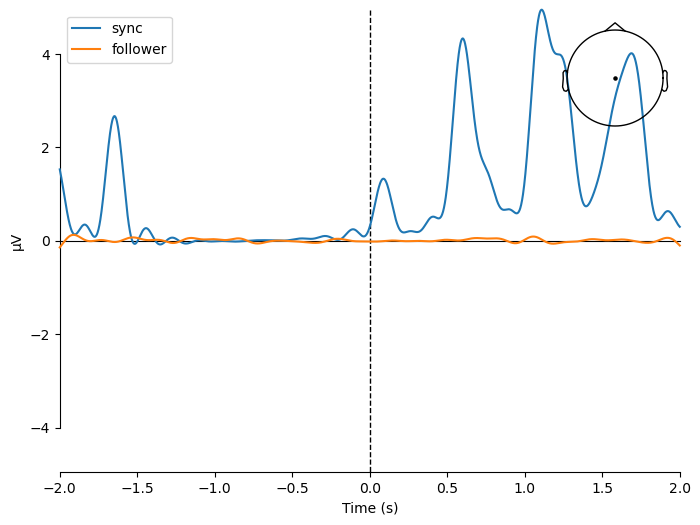

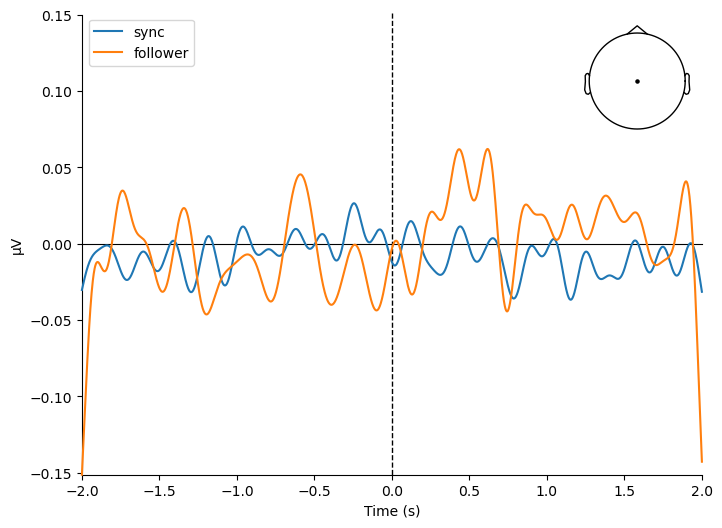

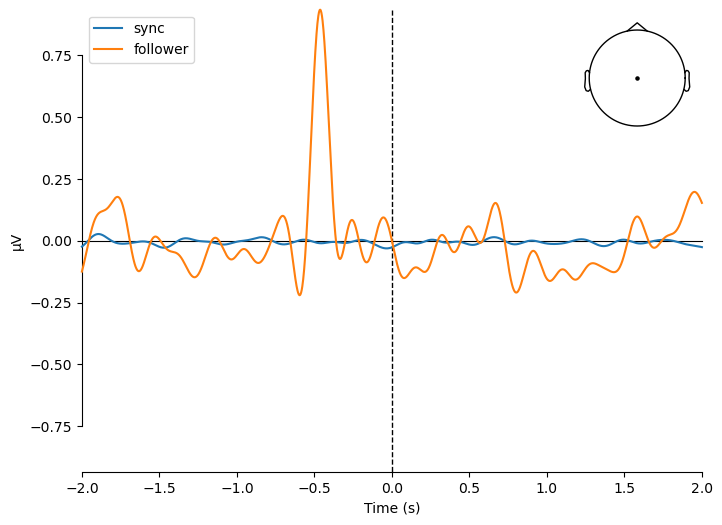

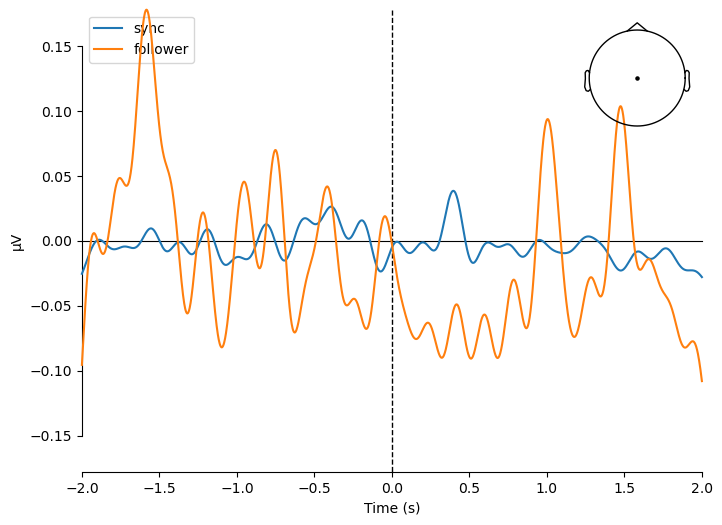

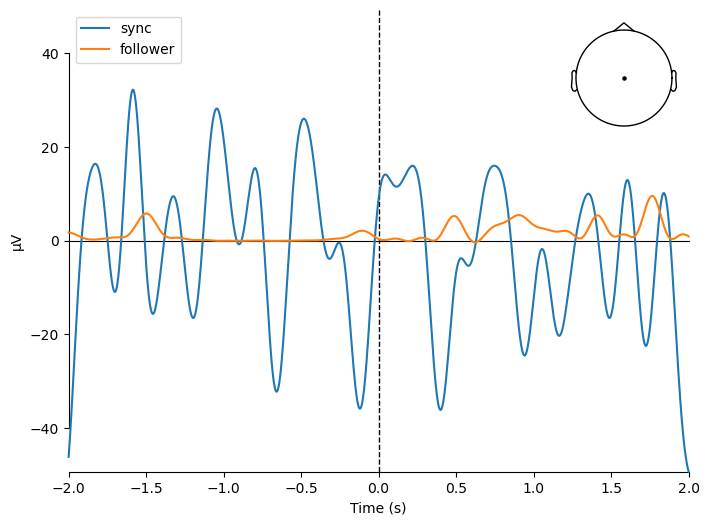

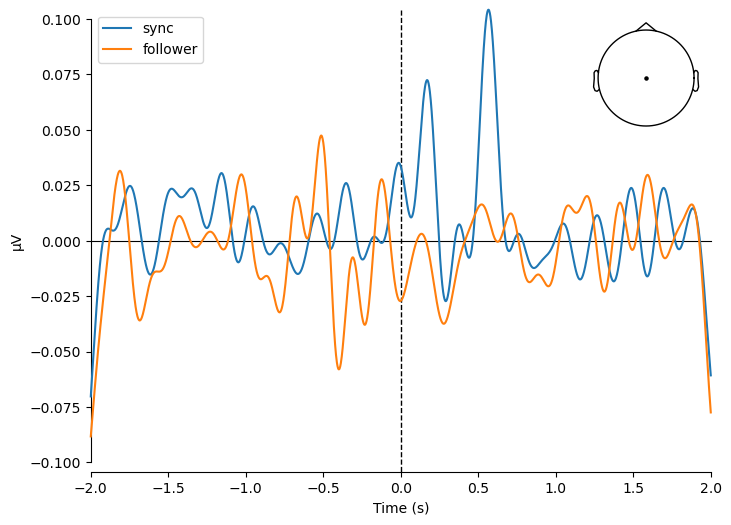

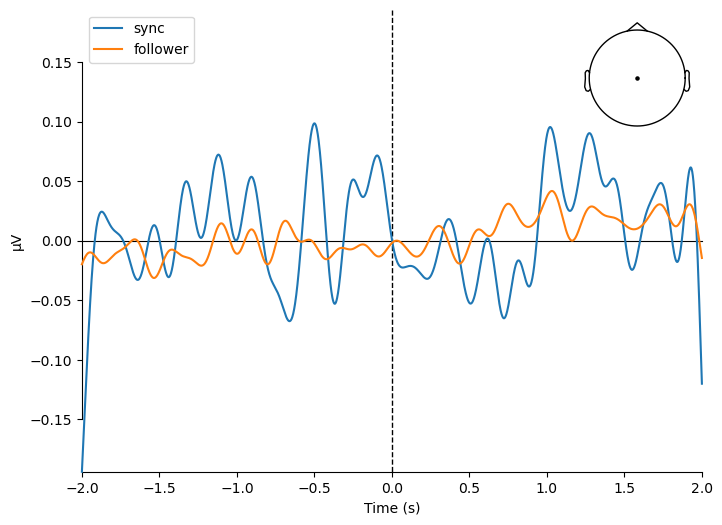

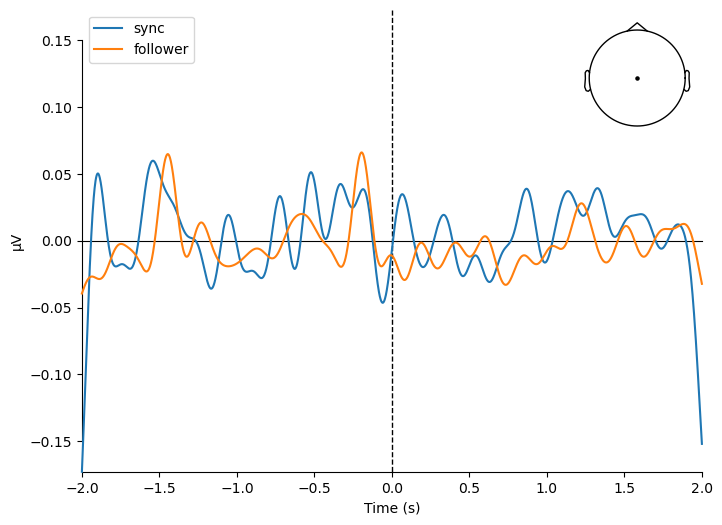

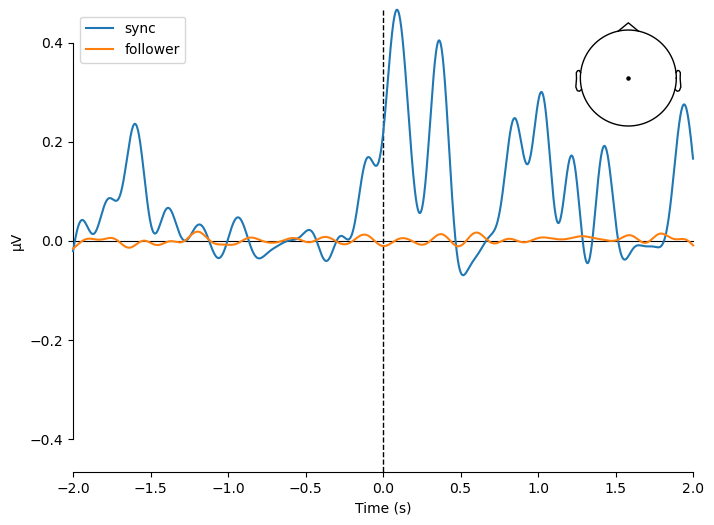

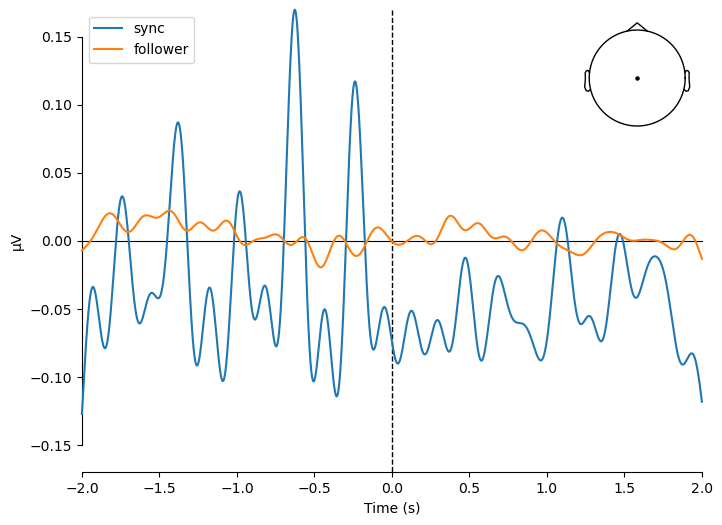

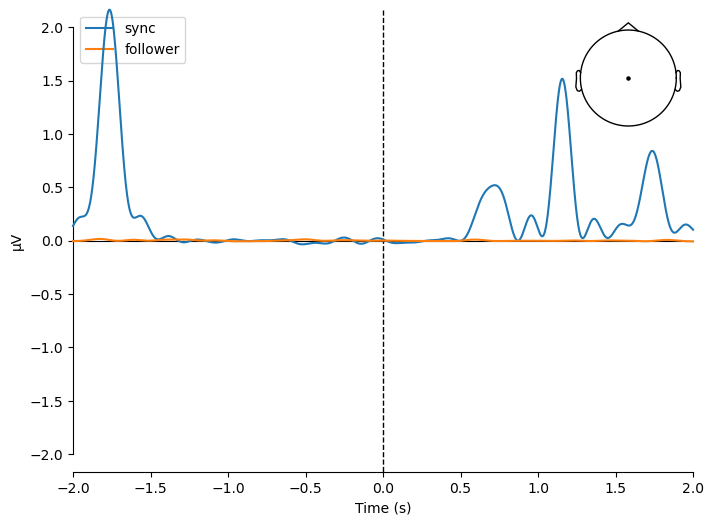

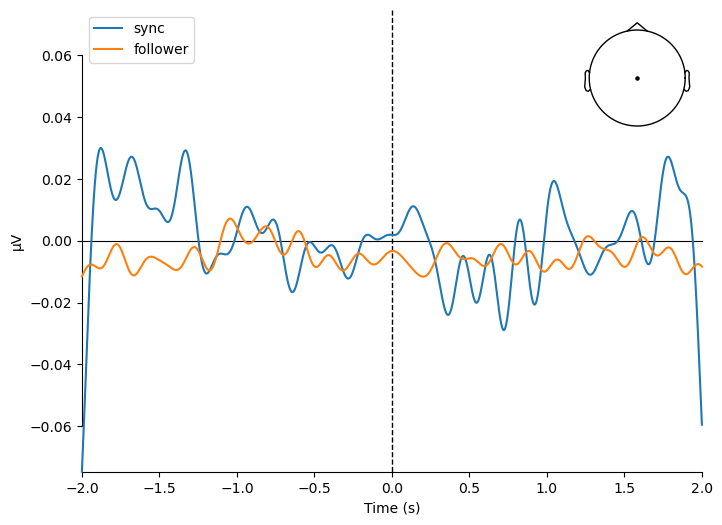

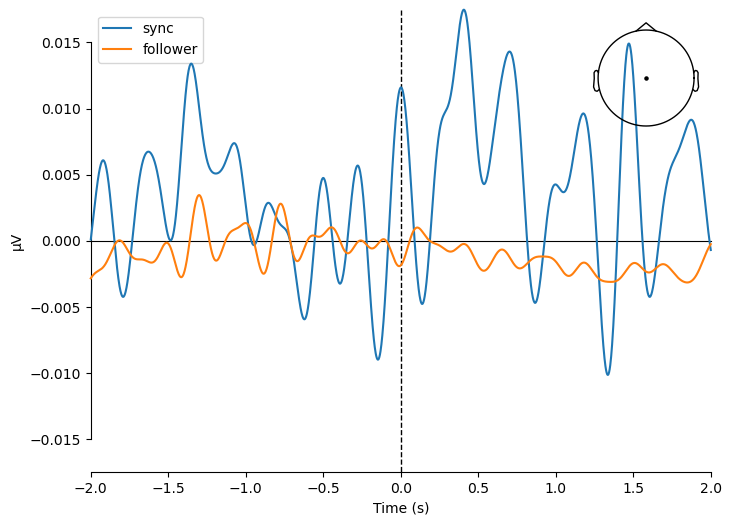

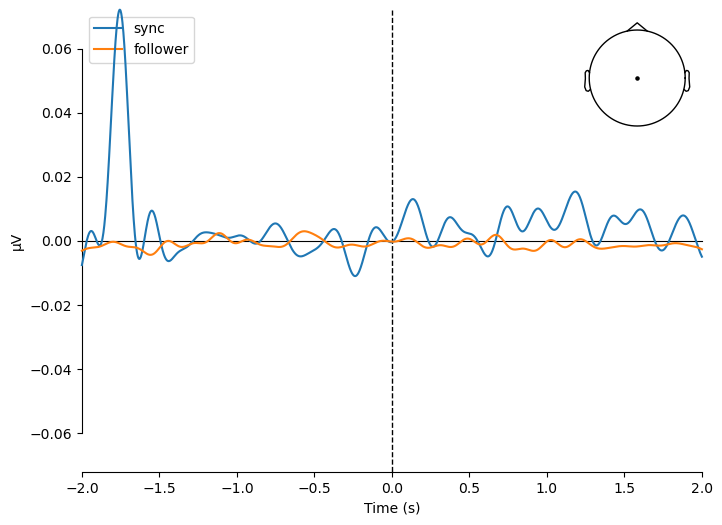

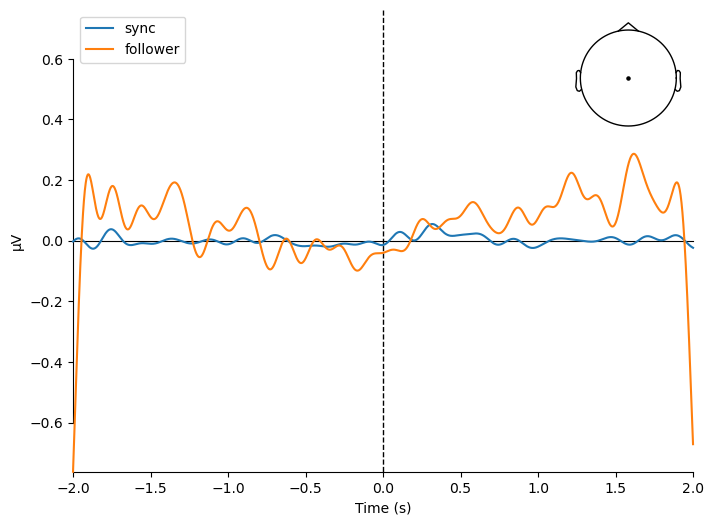

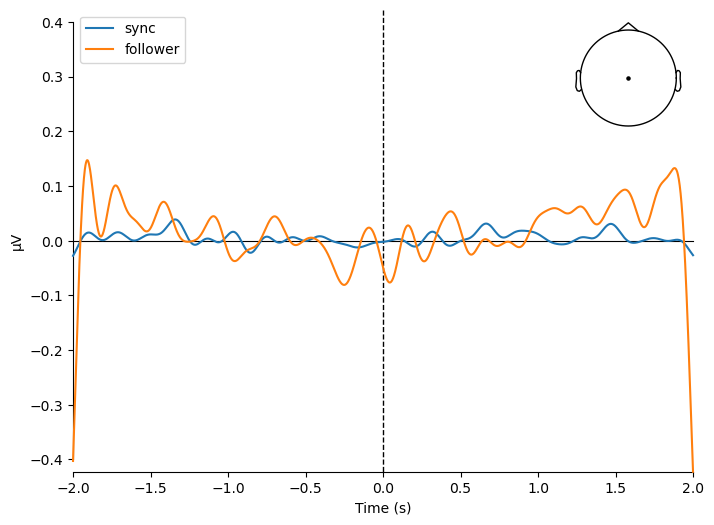

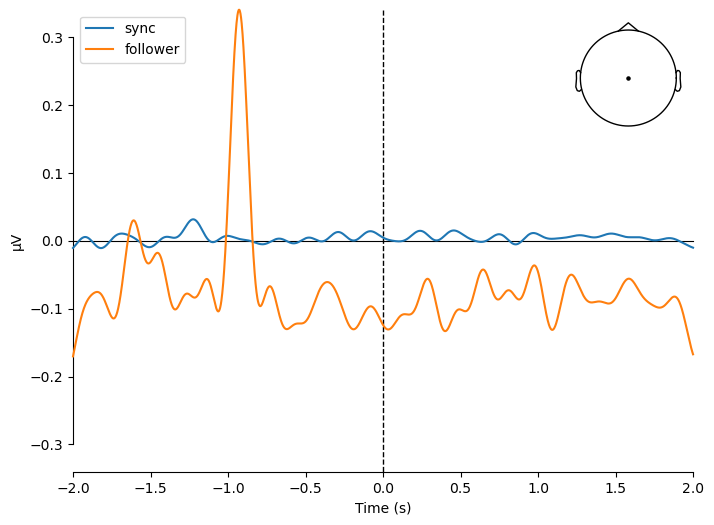

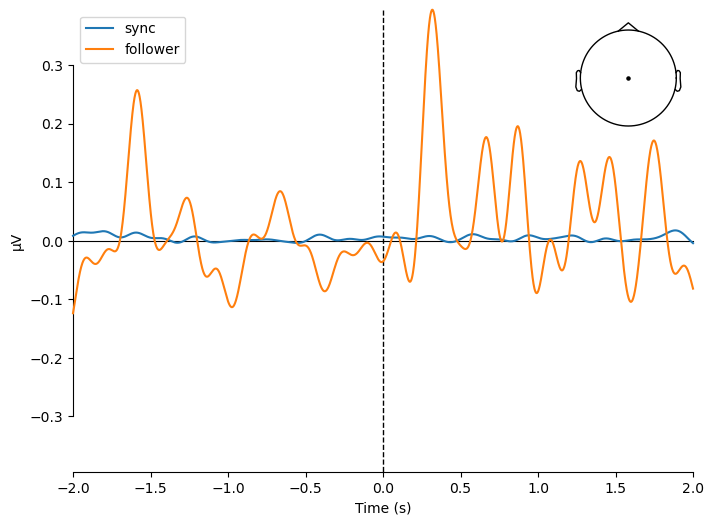

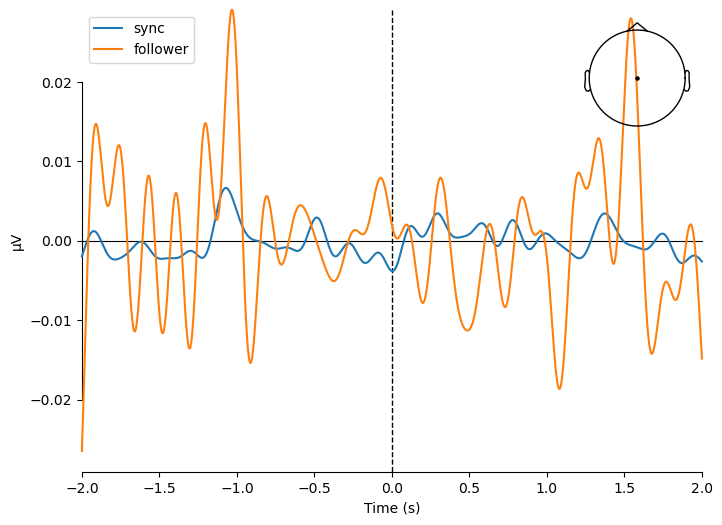

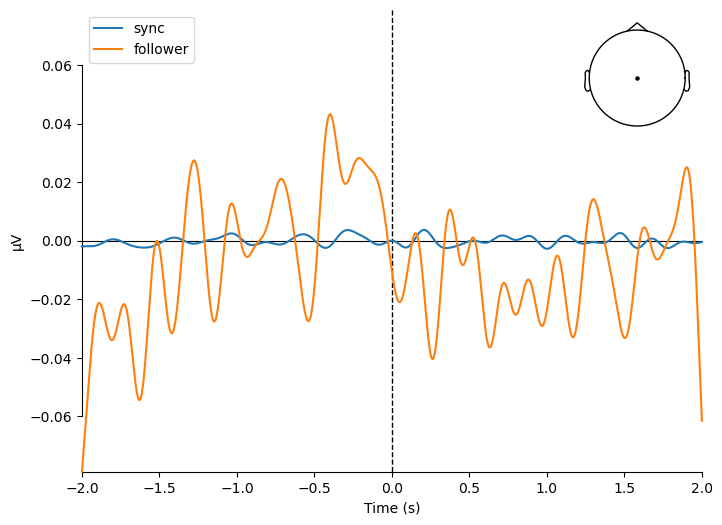

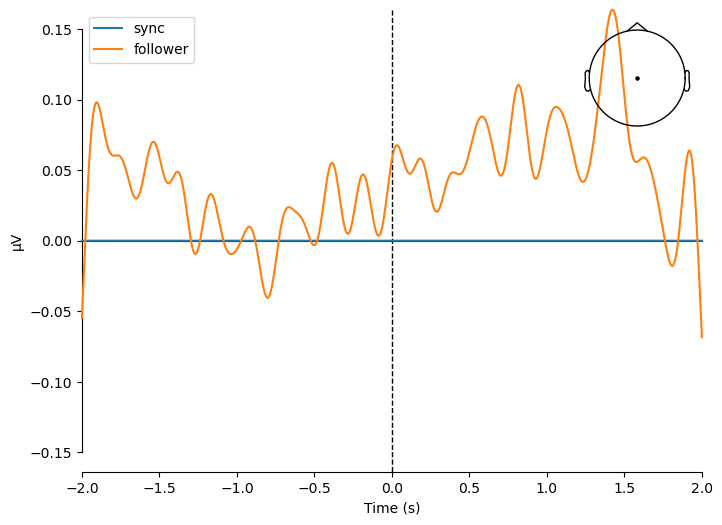

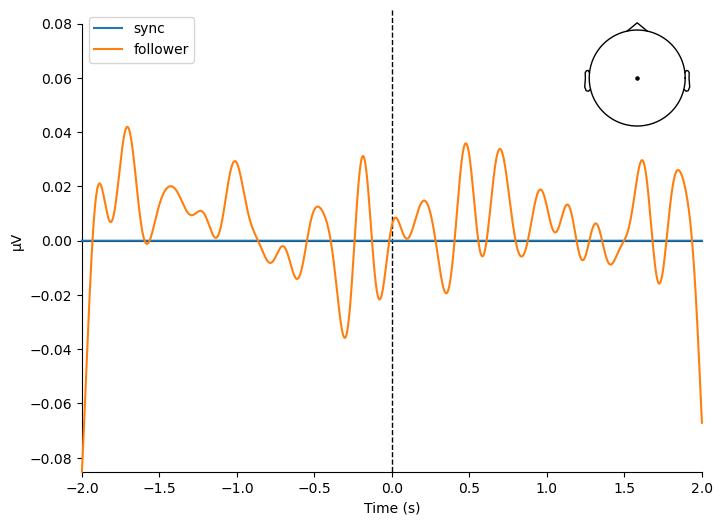

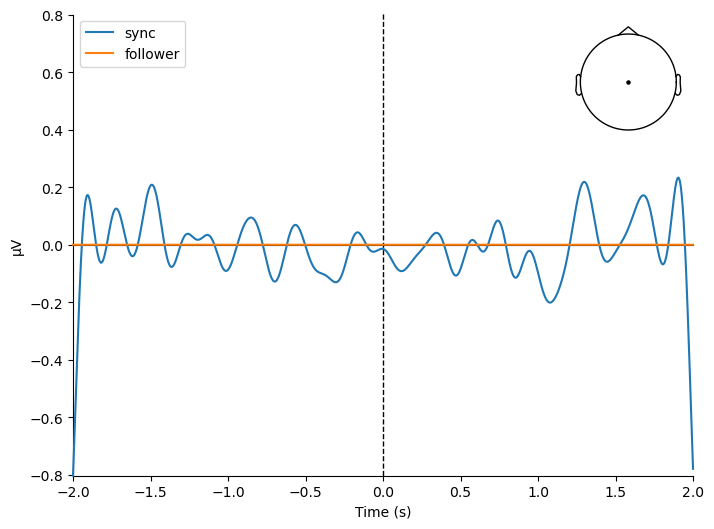

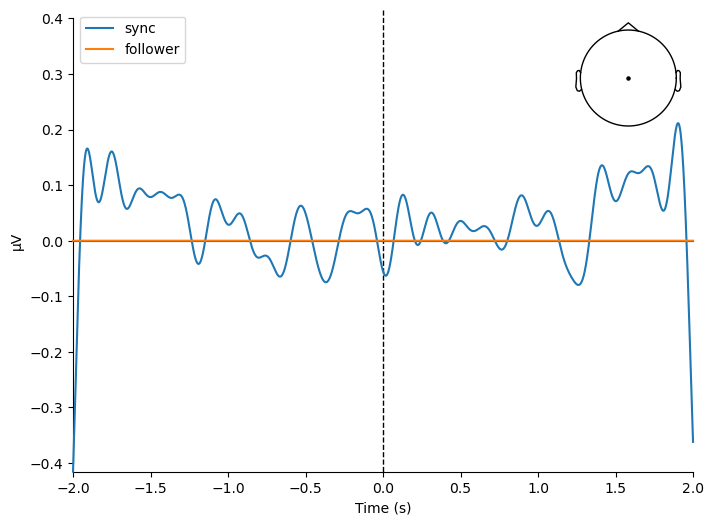

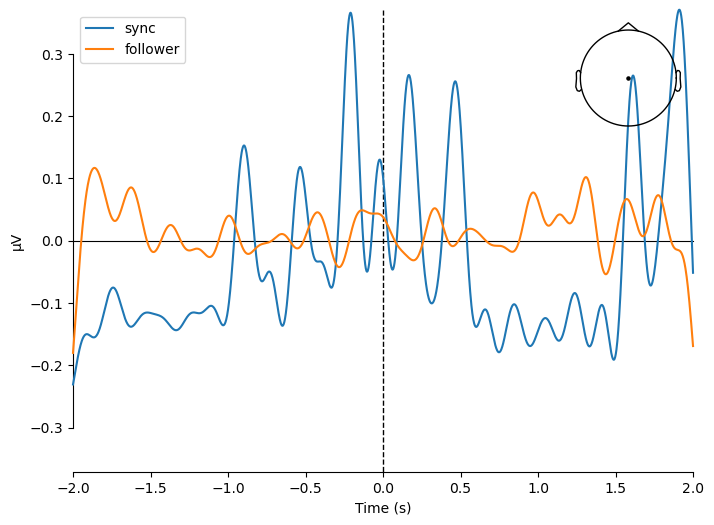

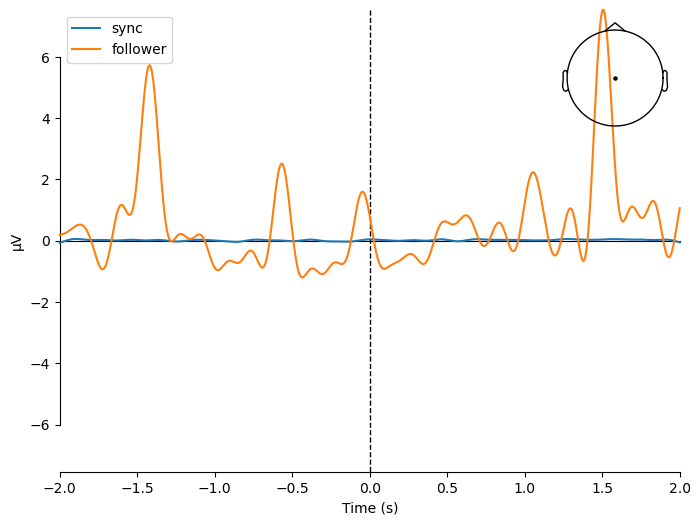

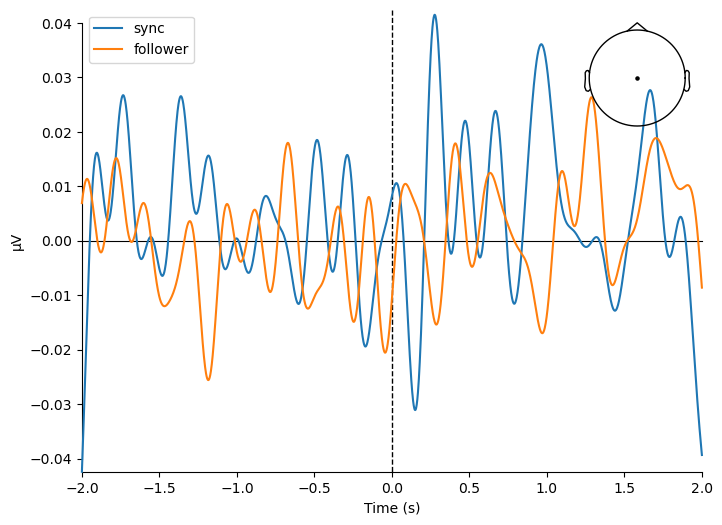

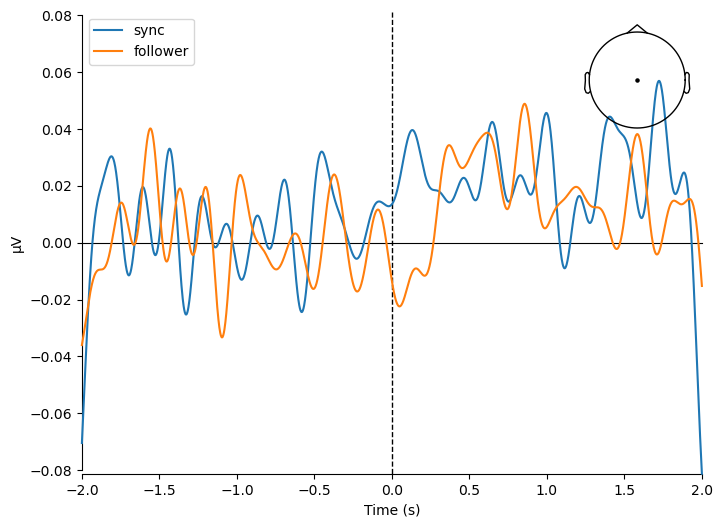

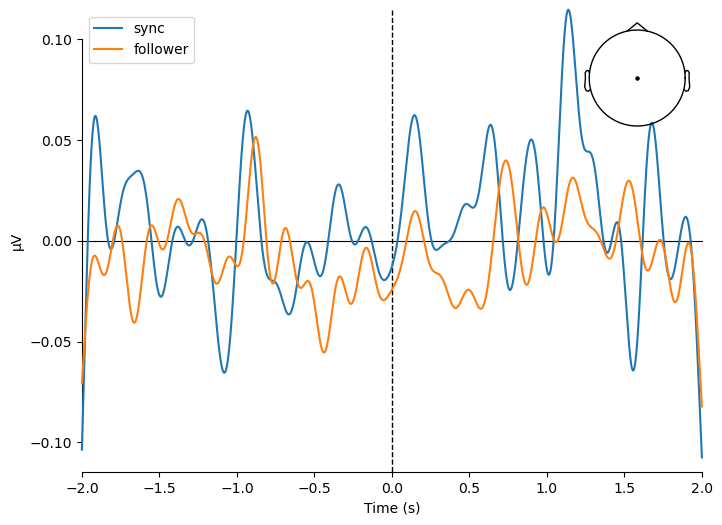

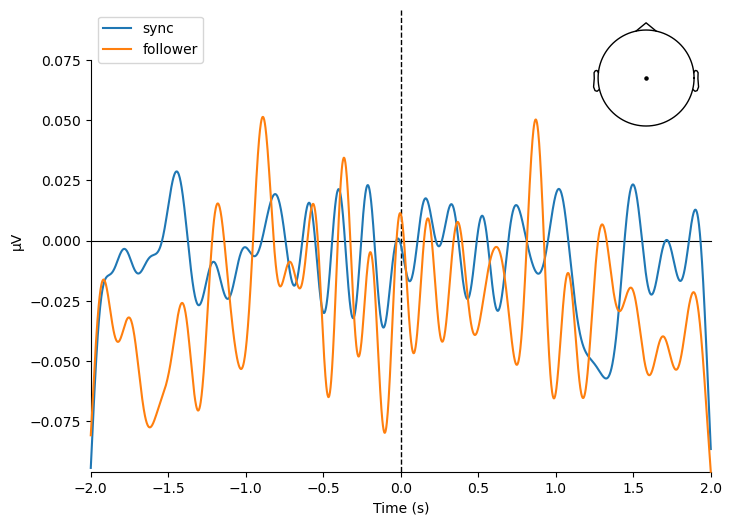

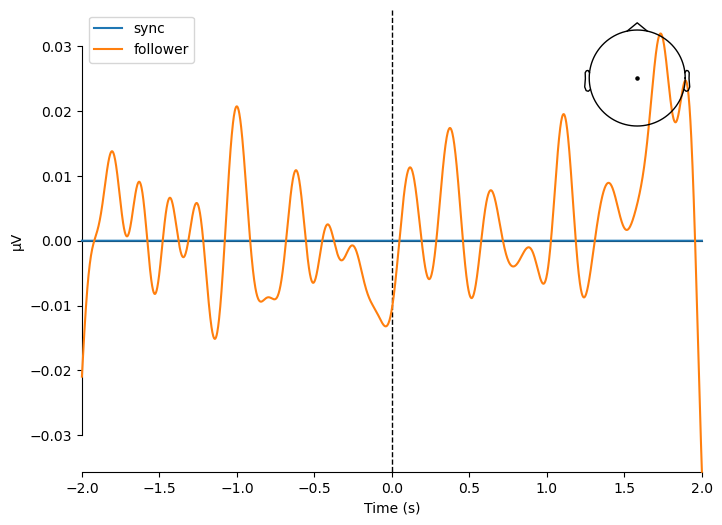

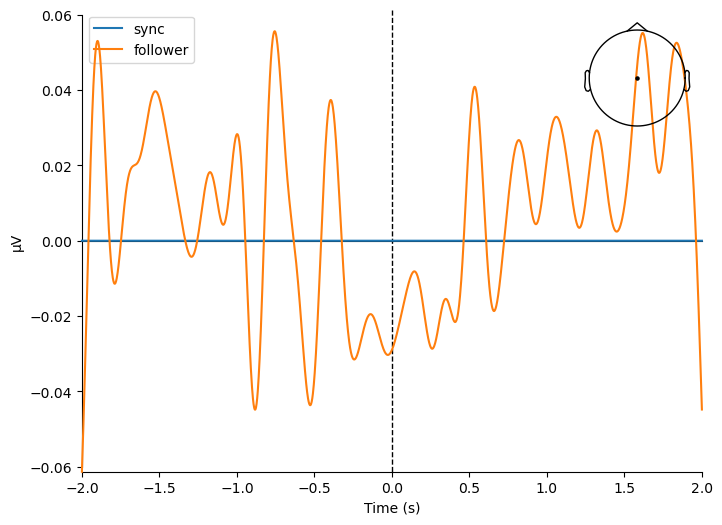

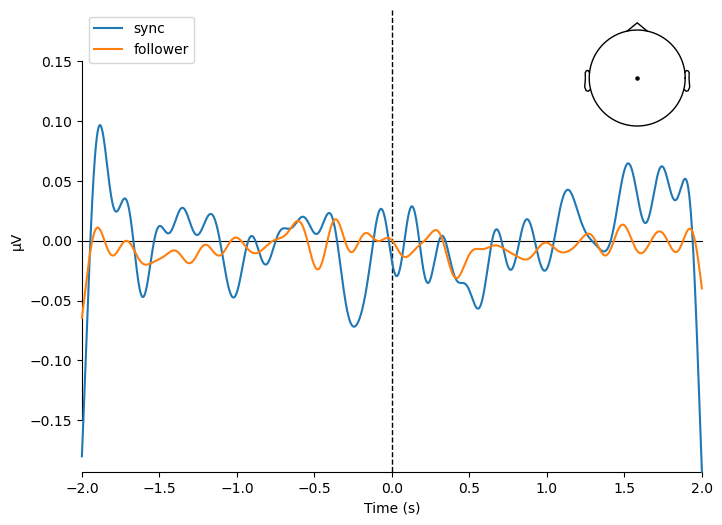

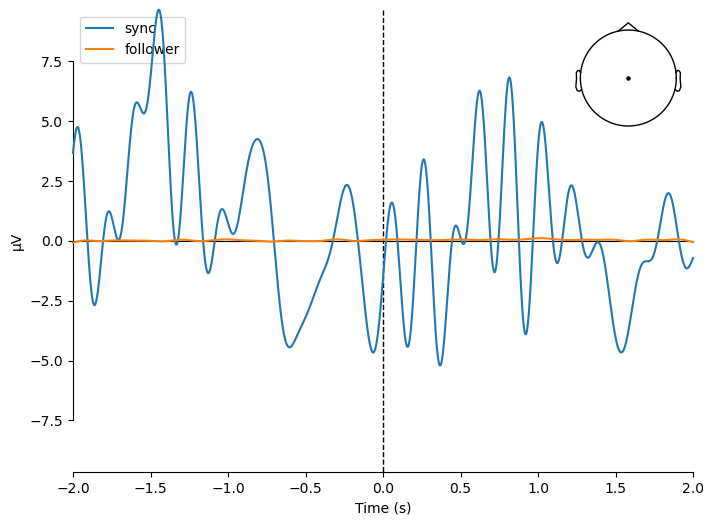

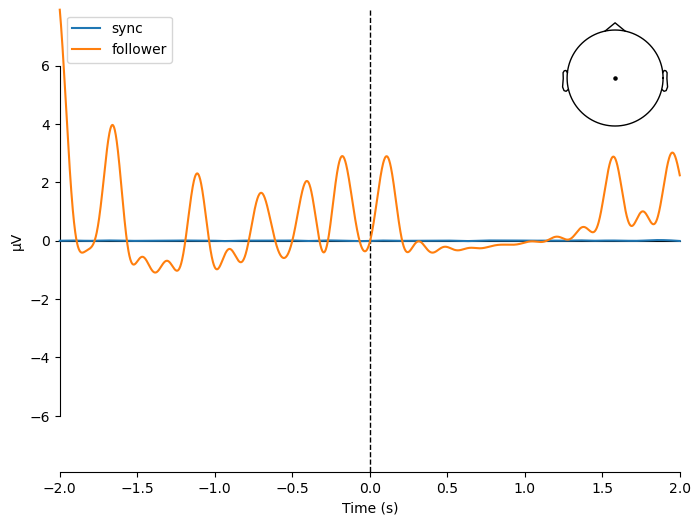

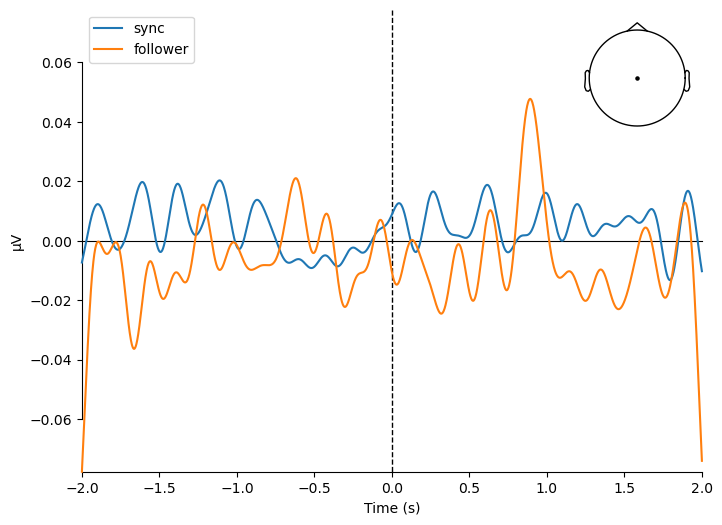

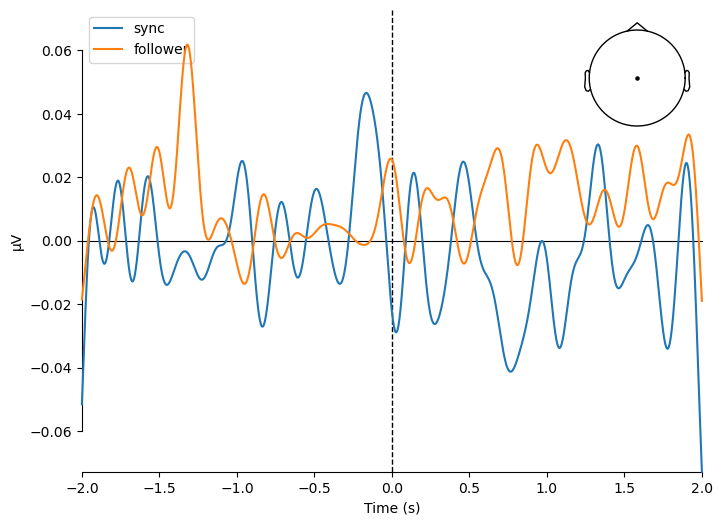

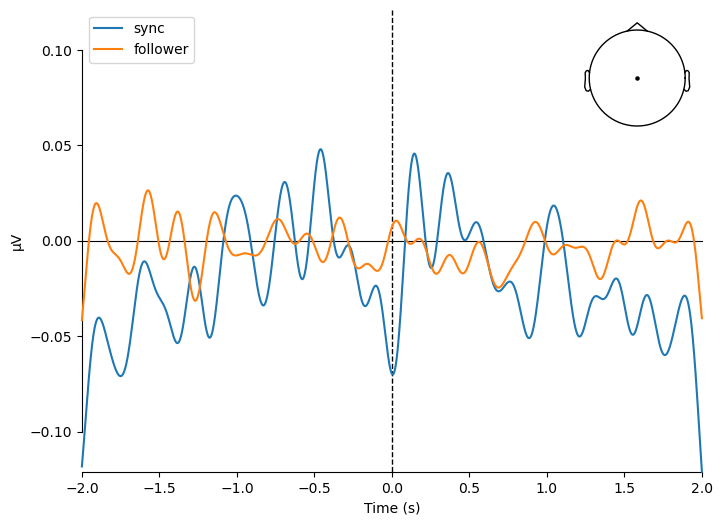

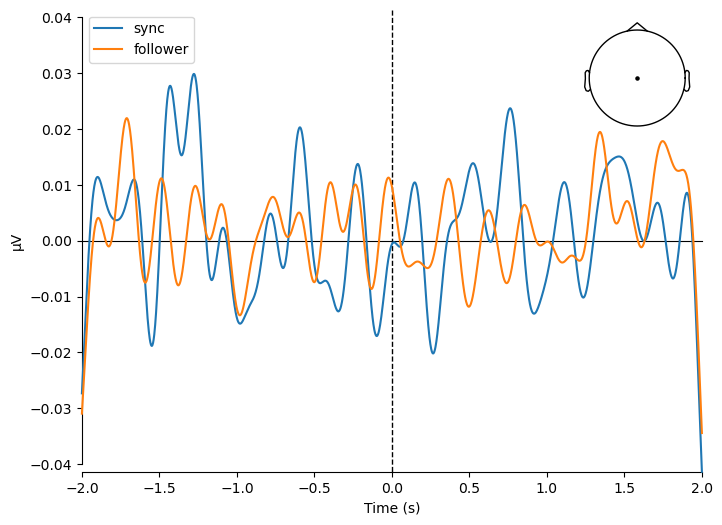

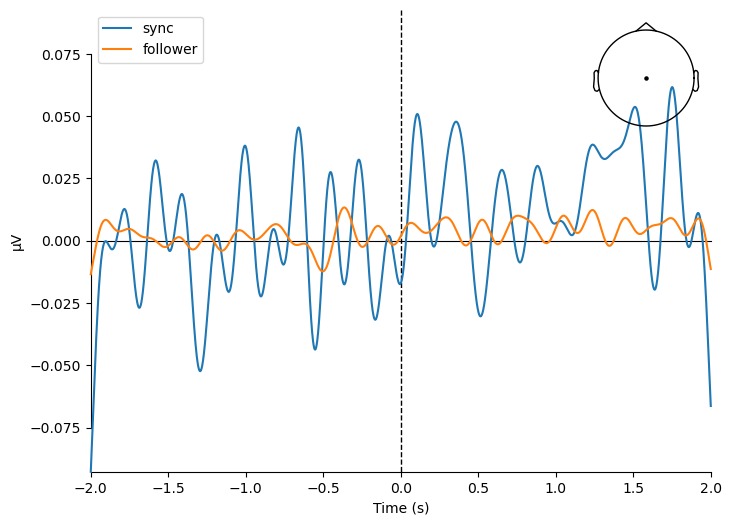

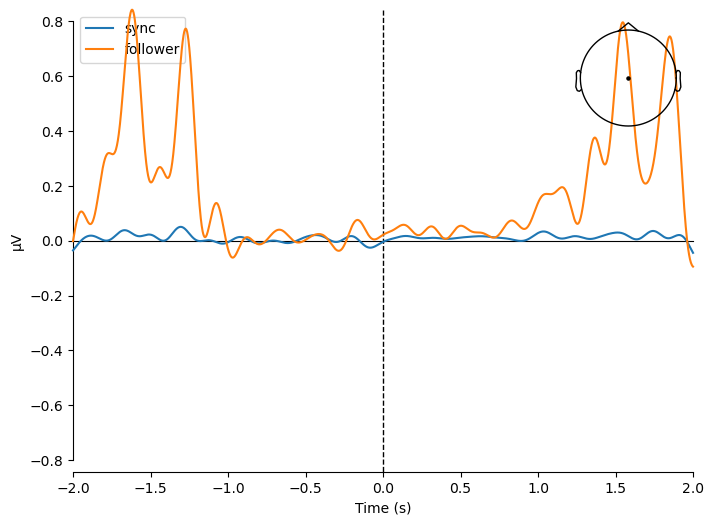

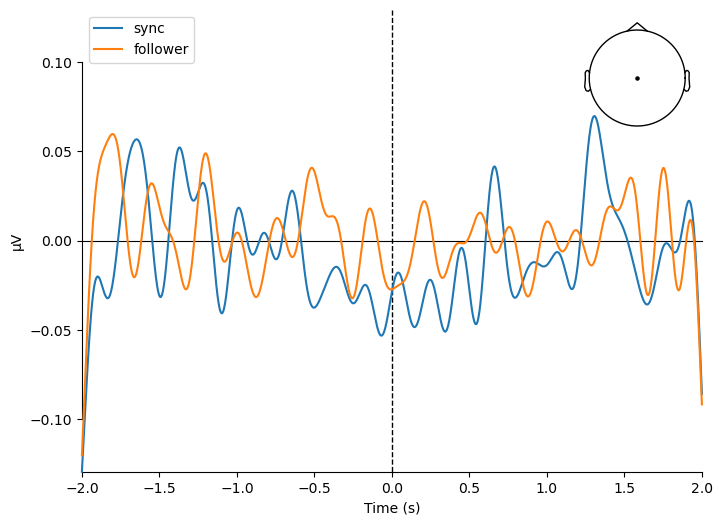

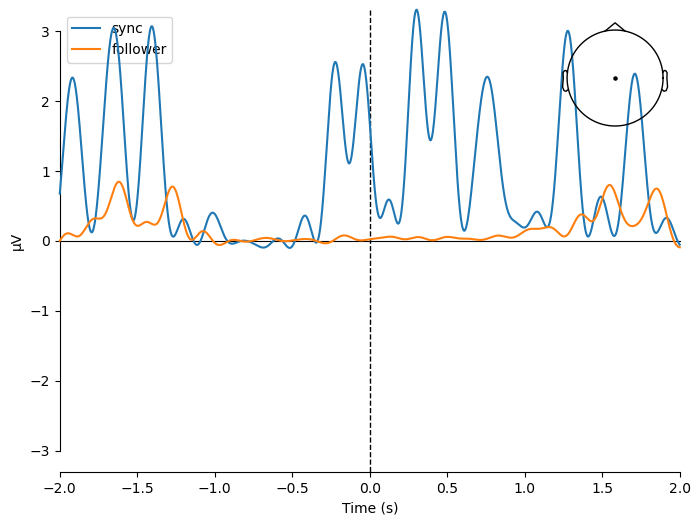

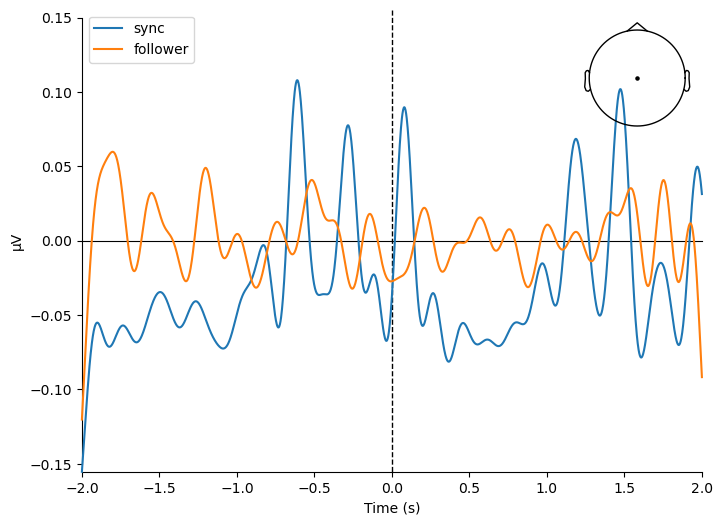

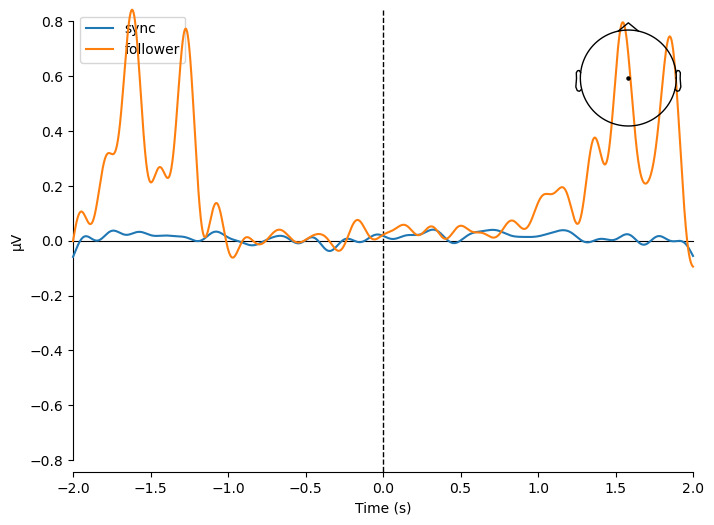

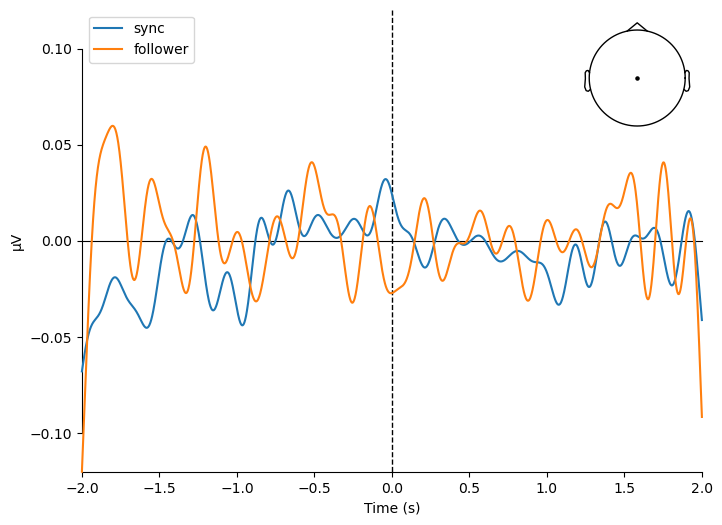

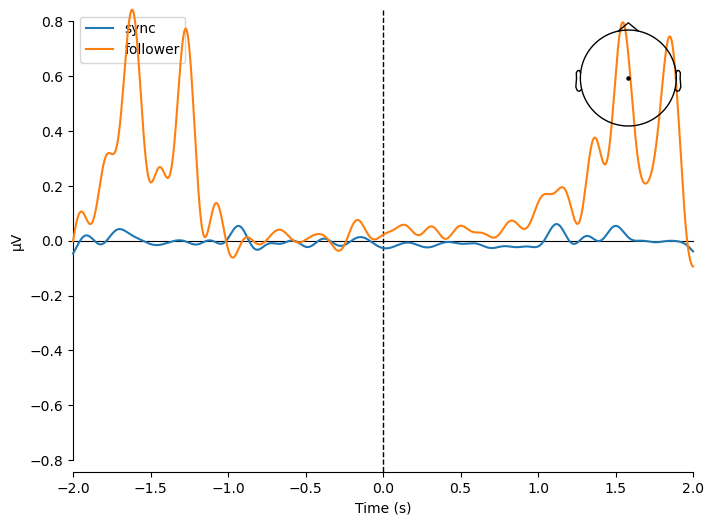

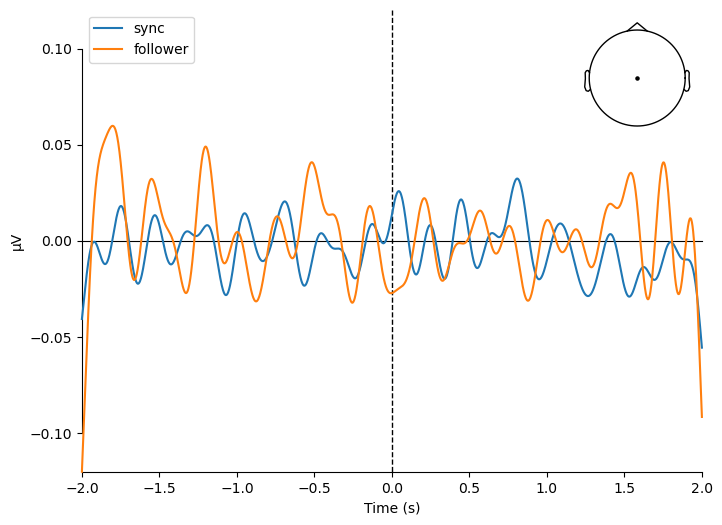

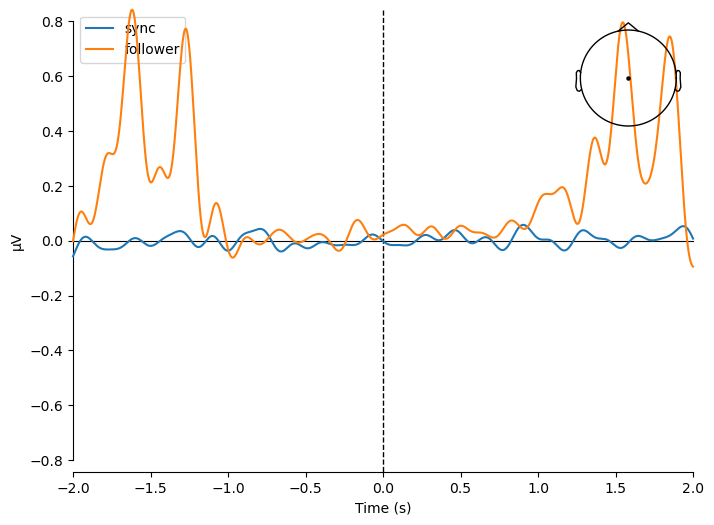

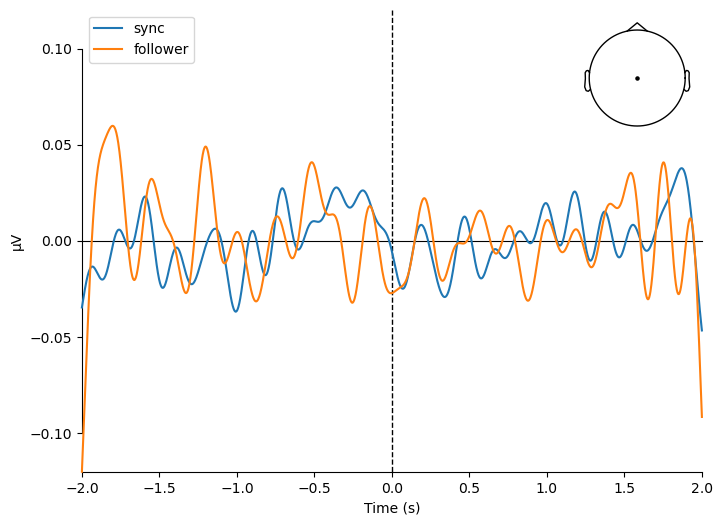

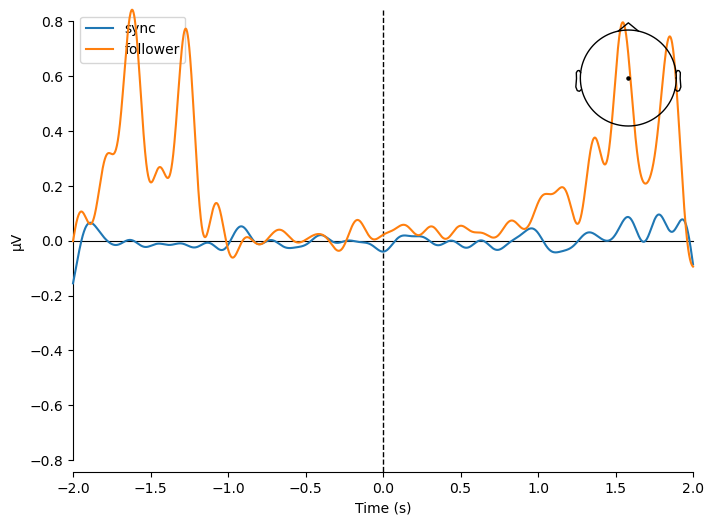

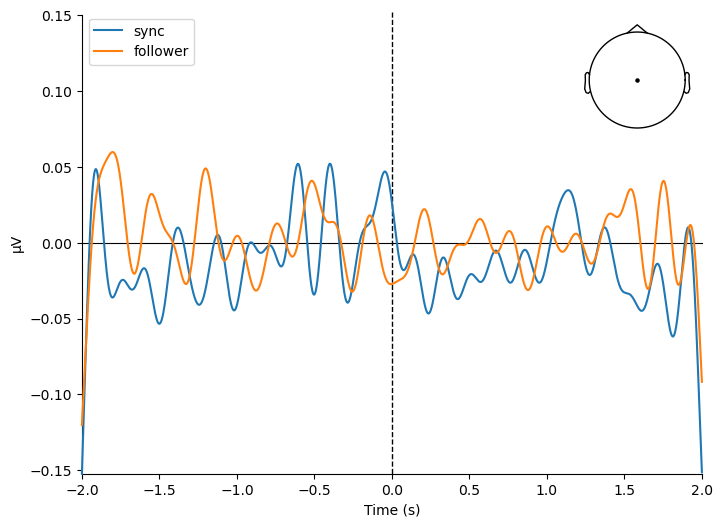

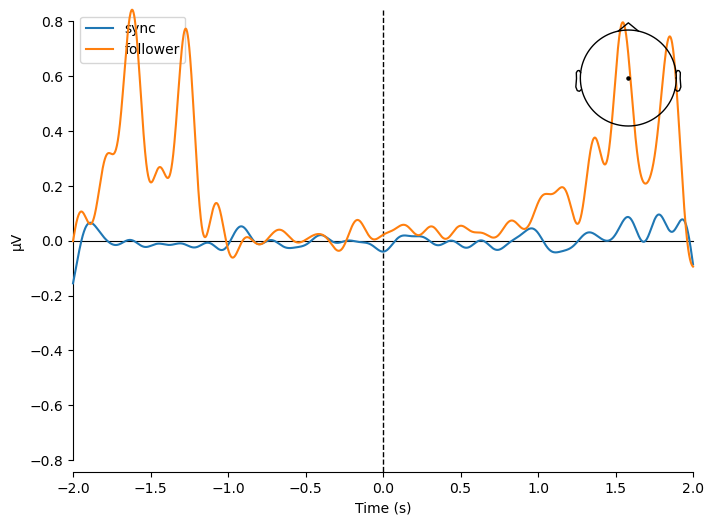

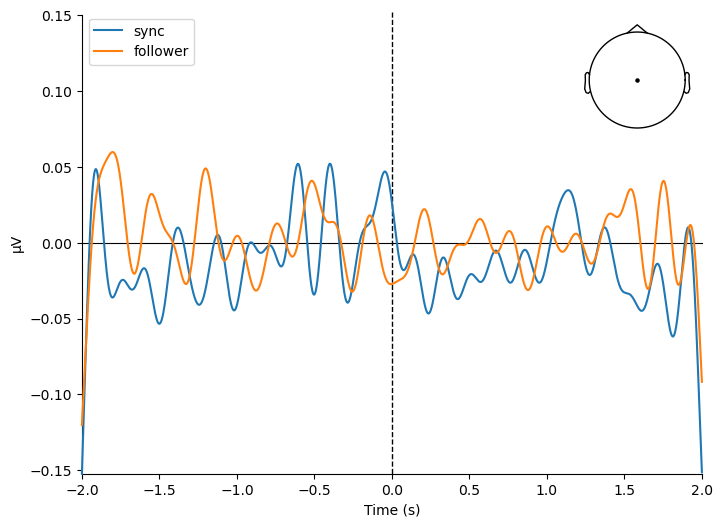

IndexError: list index out of range

In [69]:
# make an average of all the players
grand_average_desync_leader = mne.combine_evoked(evoked_desync_leader, weights = 'equal')
grand_average_desync_follower = mne.combine_evoked(evoked_desync_follower, weights = 'equal')
grand_average_sync_leader = mne.combine_evoked(evoked_sync_leader, weights = 'equal')
grand_average_sync_follower = mne.combine_evoked(evoked_sync_follower, weights = 'equal')

evokeds_desync = dict(leader = grand_average_desync_leader, follower = grand_average_desync_follower)
evokeds_sync = dict(leader = grand_average_sync_leader, follower = grand_average_sync_follower)
mne.viz.plot_compare_evokeds(evokeds_desync)
mne.viz.plot_compare_evokeds(evokeds_sync)   

for i in range(np.size(evoked_desync_leader, 0)):
    evokeds_sync = dict(sync = evoked_sync_leader[i], follower = evoked_sync_follower[i])
    mne.viz.plot_compare_evokeds(evokeds_sync)


In [ ]:
path = r"F:/hyperscanning_mne"
storepath = os.path.join(path,"time_locked", "evoked_sync_desync")
with open(storepath, "wb") as output_file: 
            pickle.dump([evokeds_desync, evokeds_sync, average_desync, average_sync], output_file, protocol=pickle.HIGHEST_PROTOCOL)
  